# Environment

In [1]:
import fitbit

import pandas as pd
import numpy as np
from datetime import datetime
from fbprophet import Prophet

import matplotlib.pyplot as plt
%matplotlib inline
from pandas import Series
from fbprophet import Prophet

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric, plot_forecast_component

import math

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

from pylab import rcParams

# Visualizations
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# Acquisition

In [2]:
chunks = fitbit.get_fitbit(files=['2018-04-26_through_2018-05-26.csv',
                           '2018-05-27_through_2018-06-26.csv',
                           '2018-06-27_through_2018-07-27.csv',
                           '2018-07-28_through_2018-08-26.csv',
                           '2018-08-27_through_2018-09-26.csv',
                           '2018-09-27_through_2018-10-27.csv',
                           '2018-10-28_through_2018-11-27.csv',
                           '2018-11-28_through_2018-12-28.csv'])

chunks = fitbit.clean_fitbit(chunks, cols=['Date', 'Calories Burned', 'Steps',
                            'Distance', 'Floors', 'Minutes Sedentary',
                            'Minutes Lightly Active', 'Minutes Fairly Active',
                            'Minutes Very Active', 'Activity Calories'])


# Preparation

In [3]:
df = fitbit.prepare_fitbit(chunks, 8, 'Date')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 224 entries, 2018-04-26 to 2018-12-06
Data columns (total 9 columns):
Calories Burned           224 non-null object
Steps                     224 non-null object
Distance                  224 non-null float64
Floors                    224 non-null float64
Minutes Sedentary         224 non-null object
Minutes Lightly Active    224 non-null float64
Minutes Fairly Active     224 non-null float64
Minutes Very Active       224 non-null float64
Activity Calories         224 non-null object
dtypes: float64(5), object(4)
memory usage: 17.5+ KB


In [5]:
fitbit.missing_values_col(df)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
Calories Burned,0,0.0,0,0.0,0,0.0
Steps,0,0.0,0,0.0,0,0.0
Distance,0,0.0,0,0.0,0,0.0
Floors,0,0.0,0,0.0,0,0.0
Minutes Sedentary,0,0.0,0,0.0,0,0.0
Minutes Lightly Active,0,0.0,0,0.0,0,0.0
Minutes Fairly Active,0,0.0,0,0.0,0,0.0
Minutes Very Active,0,0.0,0,0.0,0,0.0
Activity Calories,0,0.0,0,0.0,0,0.0


In [6]:
df = fitbit.convert_to_float(df, 'Calories Burned', 'Steps', 'Minutes Sedentary', 'Activity Calories')

In [7]:
fitbit.missing_values_col(df)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
Calories Burned,0,0.000000,0,0.0,0,0.0
Steps,0,0.000000,0,0.0,0,0.0
Distance,0,0.000000,0,0.0,0,0.0
Floors,0,0.000000,0,0.0,0,0.0
Minutes Sedentary,71,31.696429,0,0.0,0,0.0
Minutes Lightly Active,0,0.000000,0,0.0,0,0.0
Minutes Fairly Active,0,0.000000,0,0.0,0,0.0
Minutes Very Active,0,0.000000,0,0.0,0,0.0
Activity Calories,0,0.000000,0,0.0,0,0.0


In [8]:
# Impute NaNs with mean values
df = df.fillna(df.mean())
fitbit.missing_values_col(df)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
Calories Burned,0,0.0,0,0.0,0,0.0
Steps,0,0.0,0,0.0,0,0.0
Distance,0,0.0,0,0.0,0,0.0
Floors,0,0.0,0,0.0,0,0.0
Minutes Sedentary,0,0.0,0,0.0,0,0.0
Minutes Lightly Active,0,0.0,0,0.0,0,0.0
Minutes Fairly Active,0,0.0,0,0.0,0,0.0
Minutes Very Active,0,0.0,0,0.0,0,0.0
Activity Calories,0,0.0,0,0.0,0,0.0


# Exploration

In [9]:
fitbit.summarize_data(df)

HEAD
            Calories Burned   Steps  Distance  Floors  Minutes Sedentary  \
Date                                                                       
2018-04-26           2635.0  2931.0      1.38     2.0             1347.0   
2018-04-27           3649.0  9971.0      4.70    19.0             1158.0   
2018-04-28           3379.0  3521.0      1.66     2.0              702.0   
2018-04-29           2851.0  1639.0      0.77     0.0              891.0   
2018-04-30           2825.0  1323.0      0.62     0.0              880.0   

            Minutes Lightly Active  Minutes Fairly Active  \
Date                                                        
2018-04-26                    93.0                    0.0   
2018-04-27                   219.0                   46.0   
2018-04-28                   155.0                   22.0   
2018-04-29                   122.0                    0.0   
2018-04-30                   104.0                    0.0   

            Minutes Very Active  A

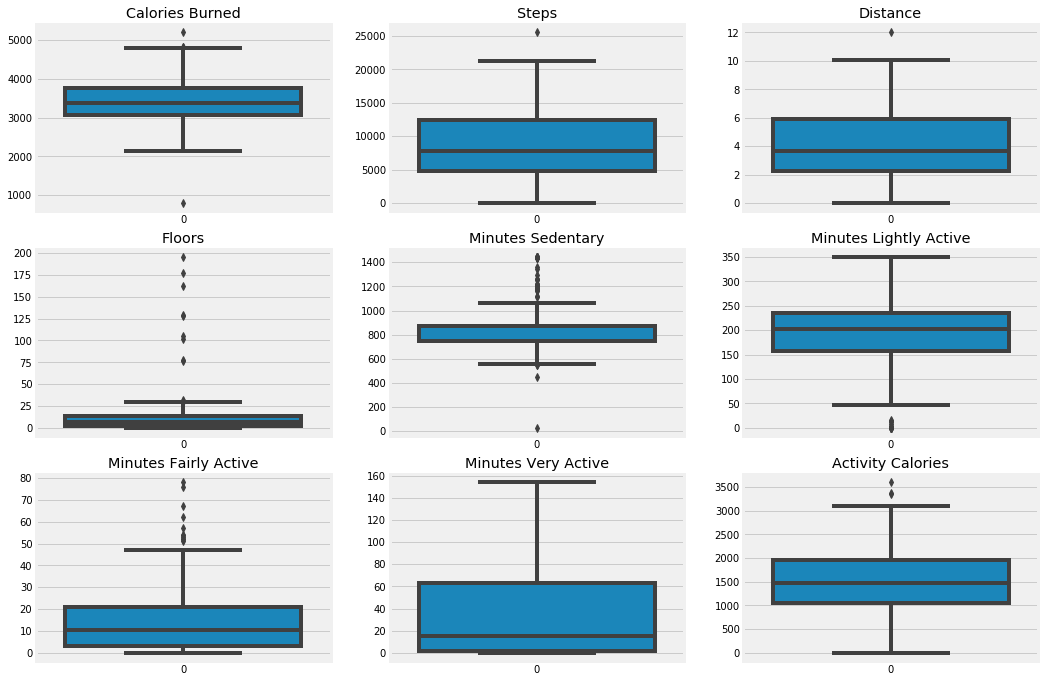

In [10]:
fitbit.plot_subs(df,
             df.select_dtypes(include='number').columns.values)

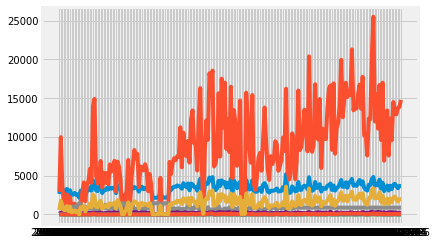

In [11]:
plt.plot(df)
plt.show()

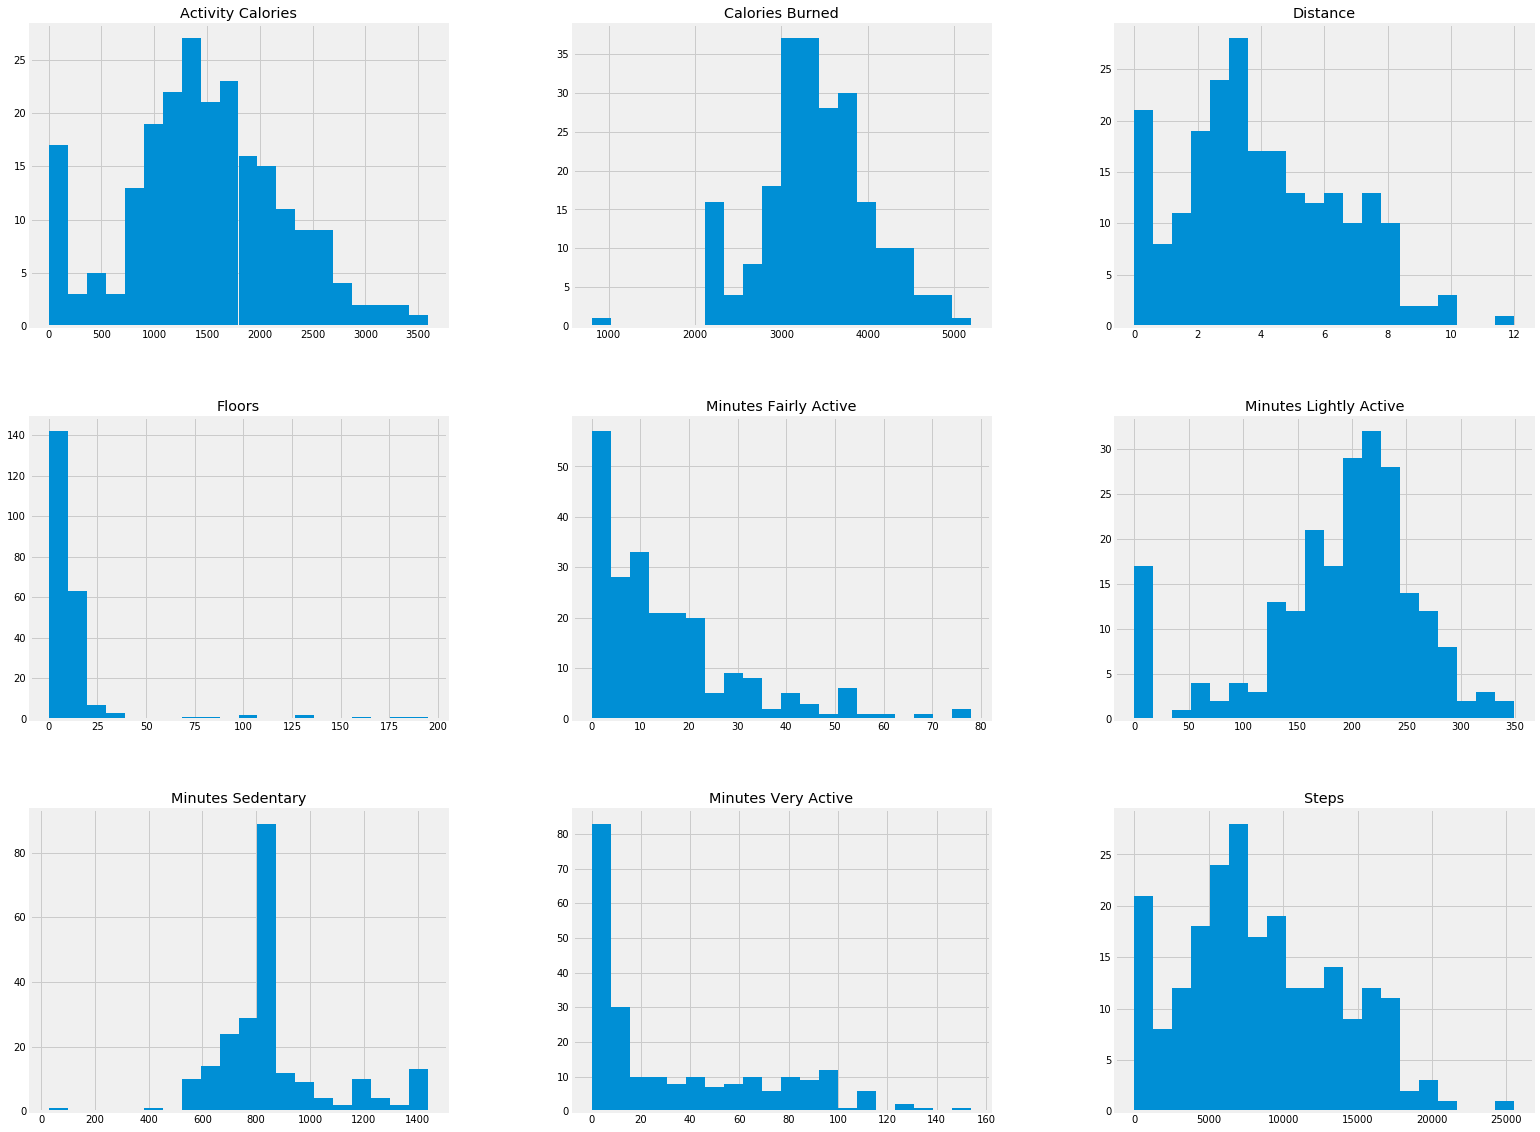

In [12]:
fitbit.plot_hist(df, 20)

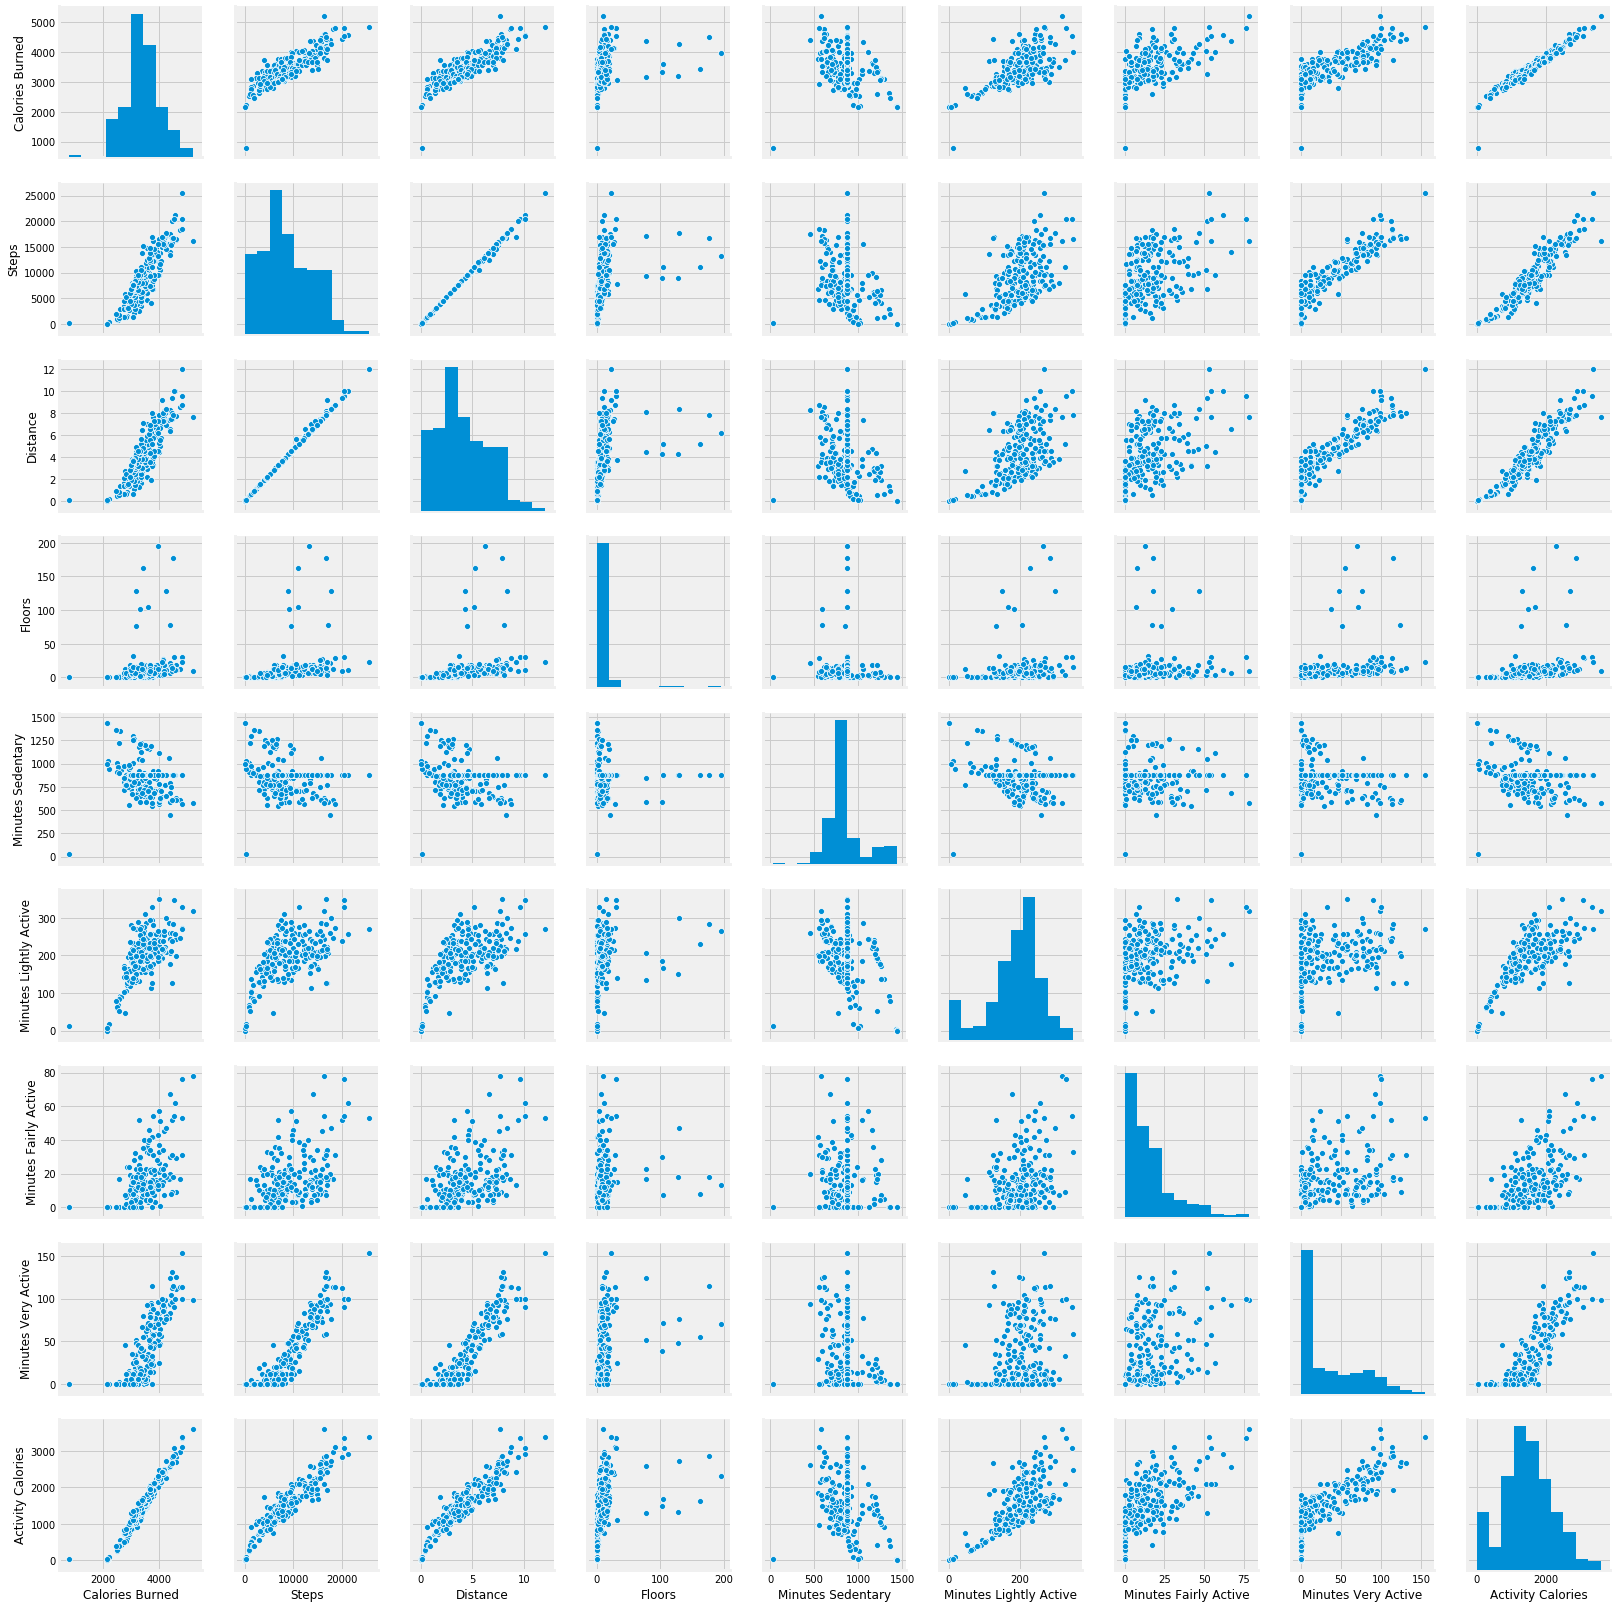

In [13]:
sns.pairplot(df)

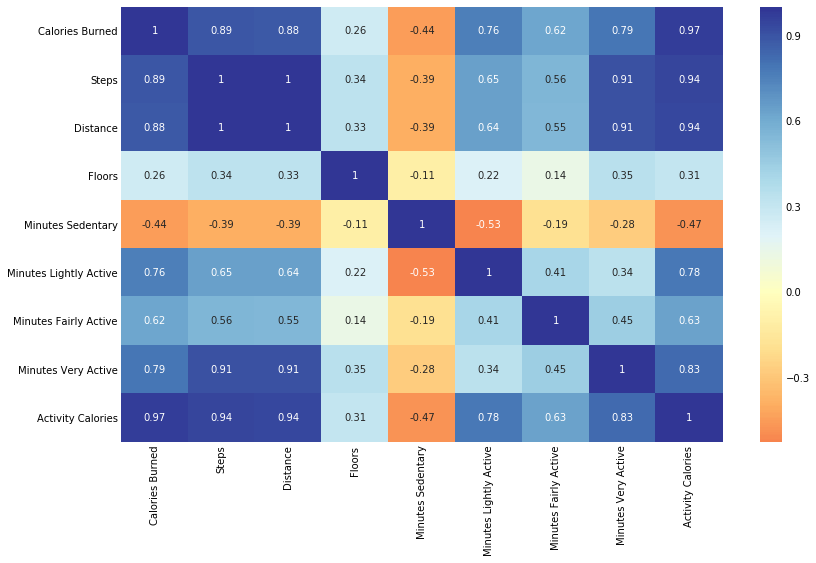

In [14]:
fitbit.plot_heat(df)

## Cleanup Missing Values

In [15]:
df = df.reset_index()

In [16]:
df.Date = pd.to_datetime(df.Date)

In [17]:
df.head()

,Date,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
0,2018-04-26,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0
1,2018-04-27,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0
2,2018-04-28,3379.0,3521.0,1.66,2.0,702.0,155.0,22.0,11.0,1124.0
3,2018-04-29,2851.0,1639.0,0.77,0.0,891.0,122.0,0.0,0.0,602.0
4,2018-04-30,2825.0,1323.0,0.62,0.0,880.0,104.0,0.0,0.0,540.0


In [18]:
def input_missing_row(df):
    missing = {'Date': '7/28/18', 'Calories Burned': 3358, 'Steps': 8073, 'Distance': 3.81, 'Floors': 5.0, 'Minutes Sedentary': 674.0, 'Minutes Lightly Active': 236.0, 'Minutes Fairly Active': 19.0, 'Minutes Very Active': 9.0, 'Activity Calories': 1481}
    df = df.append(missing, ignore_index=True)
    df.Date = pd.to_datetime(df.Date)
    df = df.sort_values(by='Date')
    return df

In [19]:
df = input_missing_row(df)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225 entries, 0 to 223
Data columns (total 10 columns):
Date                      225 non-null datetime64[ns]
Calories Burned           225 non-null float64
Steps                     225 non-null float64
Distance                  225 non-null float64
Floors                    225 non-null float64
Minutes Sedentary         225 non-null float64
Minutes Lightly Active    225 non-null float64
Minutes Fairly Active     225 non-null float64
Minutes Very Active       225 non-null float64
Activity Calories         225 non-null float64
dtypes: datetime64[ns](1), float64(9)
memory usage: 19.3 KB


In [21]:
# missing = {'Date': '7/28/18', 'Calories Burned': 3358, 'Steps': 8073, 'Distance': 3.81, 'Floors': 5.0, 'Minutes Sedentary': 674.0, 'Minutes Lightly Active': 236.0, 'Minutes Fairly Active': 19.0, 'Minutes Very Active': 9.0, 'Activity Calories': 1481}

In [22]:
# df = df.append(missing, ignore_index=True)

In [23]:
df.tail(140)

,Date,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
85,2018-07-20,3110.0,6680.0,3.15,3.0,1262.000000,136.0,28.0,14.0,1172.0
86,2018-07-21,3983.0,12279.0,5.79,10.0,569.000000,184.0,37.0,83.0,2162.0
87,2018-07-22,3883.0,13418.0,6.33,19.0,839.000000,210.0,16.0,69.0,2015.0
88,2018-07-23,3553.0,9203.0,4.34,5.0,748.000000,204.0,23.0,31.0,1597.0
89,2018-07-24,3510.0,9215.0,4.35,6.0,1203.000000,193.0,15.0,29.0,1551.0
90,2018-07-25,3069.0,5666.0,2.67,8.0,1253.000000,176.0,4.0,7.0,1062.0
91,2018-07-26,3864.0,12467.0,5.88,10.0,704.000000,214.0,11.0,58.0,1962.0
92,2018-07-27,4618.0,16306.0,7.73,18.0,634.000000,244.0,29.0,111.0,2832.0
224,2018-07-28,3358.0,8073.0,3.81,5.0,674.000000,236.0,19.0,9.0,1481.0
93,2018-07-29,3316.0,6450.0,3.04,18.0,1211.000000,192.0,17.0,20.0,1382.0


In [24]:
df = df.set_index('Date')

In [25]:
df.head()

,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
Date,,,,,,,,,
2018-04-26,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0
2018-04-27,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0
2018-04-28,3379.0,3521.0,1.66,2.0,702.0,155.0,22.0,11.0,1124.0
2018-04-29,2851.0,1639.0,0.77,0.0,891.0,122.0,0.0,0.0,602.0
2018-04-30,2825.0,1323.0,0.62,0.0,880.0,104.0,0.0,0.0,540.0


In [26]:
df = df.rename(columns={'Calories Burned': 'calories_burned'})

In [27]:
df = df.reset_index()

In [28]:
df.head()

,Date,calories_burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
0,2018-04-26,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0
1,2018-04-27,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0
2,2018-04-28,3379.0,3521.0,1.66,2.0,702.0,155.0,22.0,11.0,1124.0
3,2018-04-29,2851.0,1639.0,0.77,0.0,891.0,122.0,0.0,0.0,602.0
4,2018-04-30,2825.0,1323.0,0.62,0.0,880.0,104.0,0.0,0.0,540.0


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 10 columns):
Date                      225 non-null datetime64[ns]
calories_burned           225 non-null float64
Steps                     225 non-null float64
Distance                  225 non-null float64
Floors                    225 non-null float64
Minutes Sedentary         225 non-null float64
Minutes Lightly Active    225 non-null float64
Minutes Fairly Active     225 non-null float64
Minutes Very Active       225 non-null float64
Activity Calories         225 non-null float64
dtypes: datetime64[ns](1), float64(9)
memory usage: 17.7 KB


In [30]:
df = df.set_index('Date')

In [31]:
df.head()

,calories_burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
Date,,,,,,,,,
2018-04-26,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0
2018-04-27,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0
2018-04-28,3379.0,3521.0,1.66,2.0,702.0,155.0,22.0,11.0,1124.0
2018-04-29,2851.0,1639.0,0.77,0.0,891.0,122.0,0.0,0.0,602.0
2018-04-30,2825.0,1323.0,0.62,0.0,880.0,104.0,0.0,0.0,540.0


In [32]:
cal_burned = df.resample('D').calories_burned.mean()

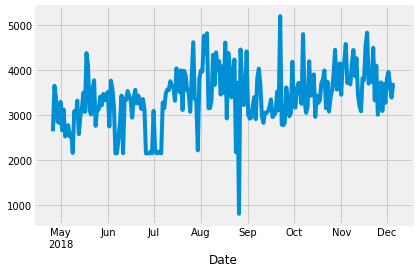

In [33]:
cal_burned.plot()

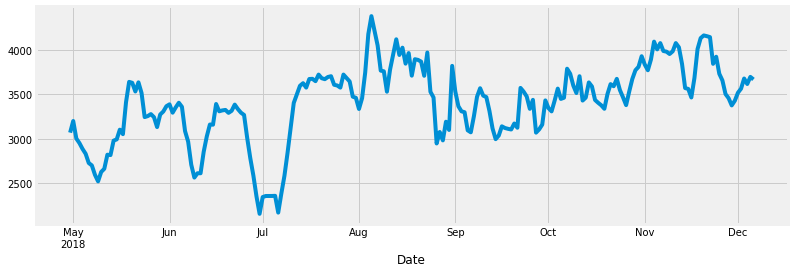

In [34]:
cal_burned.rolling(5).mean().plot(figsize=(12, 4))

In [35]:
cal_burned = cal_burned.fillna(cal_burned.mean())

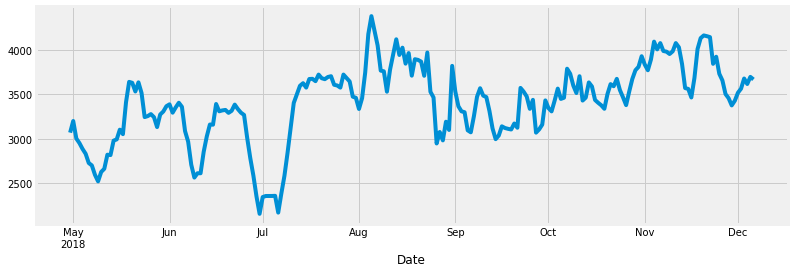

In [36]:
cal_burned.rolling(5).mean().plot(figsize=(12, 4))

In [37]:
df.calories_burned = df.calories_burned.fillna(cal_burned.mean())

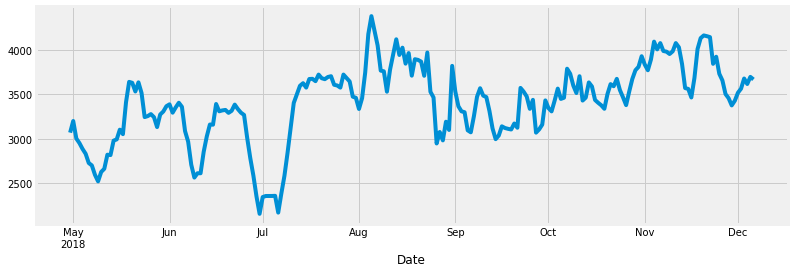

In [38]:
df.calories_burned.rolling(5).mean().plot(figsize=(12, 4))

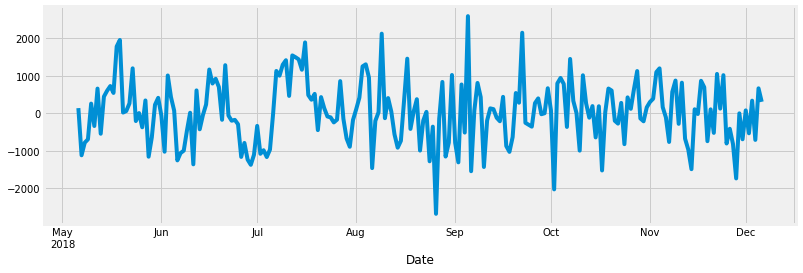

In [39]:
cal_burned.diff(periods=10).plot(figsize=(12, 4))

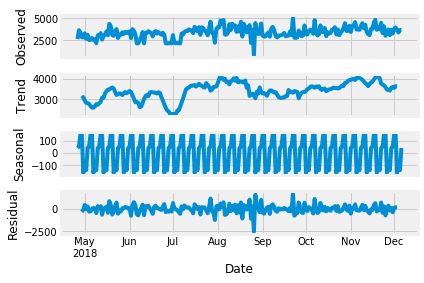

In [40]:
decomposition = sm.tsa.seasonal_decompose(cal_burned, model='additive')
fig = decomposition.plot()
plt.show()

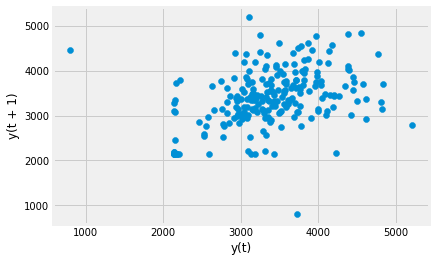

In [41]:
pd.plotting.lag_plot(cal_burned)

In [42]:
df_corr = pd.concat([cal_burned.shift(1), cal_burned], axis=1)
df_corr.columns = ['t-1','t+1']
result = df_corr.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.348927
t+1  0.348927  1.000000


In [43]:
date_range = df.index

In [44]:
date_range

DatetimeIndex(['2018-04-26', '2018-04-27', '2018-04-28', '2018-04-29',
               '2018-04-30', '2018-05-01', '2018-05-02', '2018-05-03',
               '2018-05-04', '2018-05-05',
               ...
               '2018-11-27', '2018-11-28', '2018-11-29', '2018-11-30',
               '2018-12-01', '2018-12-02', '2018-12-03', '2018-12-04',
               '2018-12-05', '2018-12-06'],
              dtype='datetime64[ns]', name='Date', length=225, freq=None)

In [45]:
df.head()

,calories_burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
Date,,,,,,,,,
2018-04-26,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0
2018-04-27,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0
2018-04-28,3379.0,3521.0,1.66,2.0,702.0,155.0,22.0,11.0,1124.0
2018-04-29,2851.0,1639.0,0.77,0.0,891.0,122.0,0.0,0.0,602.0
2018-04-30,2825.0,1323.0,0.62,0.0,880.0,104.0,0.0,0.0,540.0


In [46]:
df = df.reset_index()

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 10 columns):
Date                      225 non-null datetime64[ns]
calories_burned           225 non-null float64
Steps                     225 non-null float64
Distance                  225 non-null float64
Floors                    225 non-null float64
Minutes Sedentary         225 non-null float64
Minutes Lightly Active    225 non-null float64
Minutes Fairly Active     225 non-null float64
Minutes Very Active       225 non-null float64
Activity Calories         225 non-null float64
dtypes: datetime64[ns](1), float64(9)
memory usage: 17.7 KB


In [48]:
df.Date = pd.to_datetime(df.Date)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 10 columns):
Date                      225 non-null datetime64[ns]
calories_burned           225 non-null float64
Steps                     225 non-null float64
Distance                  225 non-null float64
Floors                    225 non-null float64
Minutes Sedentary         225 non-null float64
Minutes Lightly Active    225 non-null float64
Minutes Fairly Active     225 non-null float64
Minutes Very Active       225 non-null float64
Activity Calories         225 non-null float64
dtypes: datetime64[ns](1), float64(9)
memory usage: 17.7 KB


In [50]:
df = df.set_index('Date')

In [51]:
df.head()

,calories_burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
Date,,,,,,,,,
2018-04-26,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0
2018-04-27,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0
2018-04-28,3379.0,3521.0,1.66,2.0,702.0,155.0,22.0,11.0,1124.0
2018-04-29,2851.0,1639.0,0.77,0.0,891.0,122.0,0.0,0.0,602.0
2018-04-30,2825.0,1323.0,0.62,0.0,880.0,104.0,0.0,0.0,540.0


In [52]:
aggregation = 'sum'
ts_data = df['calories_burned'].resample('D').agg(aggregation)

In [53]:
ts_data

Date
2018-04-26    2635.0
2018-04-27    3649.0
2018-04-28    3379.0
2018-04-29    2851.0
2018-04-30    2825.0
2018-05-01    3292.0
2018-05-02    2660.0
2018-05-03    3121.0
2018-05-04    2522.0
2018-05-05    2551.0
2018-05-06    2771.0
2018-05-07    2524.0
2018-05-08    2591.0
2018-05-09    2153.0
2018-05-10    3081.0
2018-05-11    2950.0
2018-05-12    3318.0
2018-05-13    2572.0
2018-05-14    2966.0
2018-05-15    3152.0
2018-05-16    3497.0
2018-05-17    3066.0
2018-05-18    4376.0
2018-05-19    4112.0
2018-05-20    3098.0
2018-05-21    3009.0
2018-05-22    3581.0
2018-05-23    3772.0
2018-05-24    2756.0
2018-05-25    3155.0
               ...  
2018-11-07    3681.0
2018-11-08    4137.0
2018-11-09    4445.0
2018-11-10    3863.0
2018-11-11    4264.0
2018-11-12    3444.0
2018-11-13    3202.0
2018-11-14    3081.0
2018-11-15    3815.0
2018-11-16    3780.0
2018-11-17    4548.0
2018-11-18    4832.0
2018-11-19    3697.0
2018-11-20    3966.0
2018-11-21    3738.0
2018-11-22    4494.0
2018-11-

### Train / Test Split

In [54]:
train_size = int(len(ts_data) * 0.66)
train_1, test_1 = ts_data[0:train_size], ts_data[train_size:len(ts_data)]
print('Observations: %d' % (len(ts_data)))
print('Training Observations: %d' % (len(train_1)))
print('Testing Observations: %d' % (len(test_1)))

Observations: 225
Training Observations: 148
Testing Observations: 77


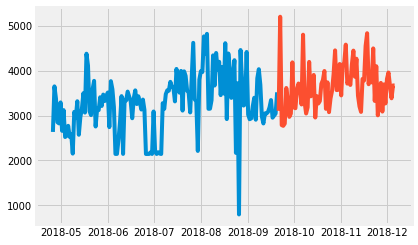

In [55]:
plt.plot(train_1)
plt.plot(test_1)
plt.show()

In [56]:
train_1

Date
2018-04-26    2635.0
2018-04-27    3649.0
2018-04-28    3379.0
2018-04-29    2851.0
2018-04-30    2825.0
2018-05-01    3292.0
2018-05-02    2660.0
2018-05-03    3121.0
2018-05-04    2522.0
2018-05-05    2551.0
2018-05-06    2771.0
2018-05-07    2524.0
2018-05-08    2591.0
2018-05-09    2153.0
2018-05-10    3081.0
2018-05-11    2950.0
2018-05-12    3318.0
2018-05-13    2572.0
2018-05-14    2966.0
2018-05-15    3152.0
2018-05-16    3497.0
2018-05-17    3066.0
2018-05-18    4376.0
2018-05-19    4112.0
2018-05-20    3098.0
2018-05-21    3009.0
2018-05-22    3581.0
2018-05-23    3772.0
2018-05-24    2756.0
2018-05-25    3155.0
               ...  
2018-08-22    3811.0
2018-08-23    4232.0
2018-08-24    2168.0
2018-08-25    3719.0
2018-08-26     799.0
2018-08-27    4458.0
2018-08-28    3757.0
2018-08-29    3222.0
2018-08-30    3253.0
2018-08-31    4415.0
2018-09-01    3020.0
2018-09-02    2918.0
2018-09-03    2936.0
2018-09-04    3201.0
2018-09-05    3395.0
2018-09-06    2907.0
2018-09-

In [57]:
train = pd.DataFrame(train_1)

In [58]:
test = pd.DataFrame(test_1)

In [59]:
train.head()

,calories_burned
Date,
2018-04-26,2635.0
2018-04-27,3649.0
2018-04-28,3379.0
2018-04-29,2851.0
2018-04-30,2825.0


In [60]:
test.head()

,calories_burned
Date,
2018-09-21,3105.0
2018-09-22,5199.0
2018-09-23,2787.0
2018-09-24,2771.0
2018-09-25,2820.0


# Modeling

## 1. Prophet

In [61]:
df = df.reset_index()
fitbit.convert_to_datetime(df, 'Date')
df.head()

,Date,calories_burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
0,2018-04-26,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0
1,2018-04-27,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0
2,2018-04-28,3379.0,3521.0,1.66,2.0,702.0,155.0,22.0,11.0,1124.0
3,2018-04-29,2851.0,1639.0,0.77,0.0,891.0,122.0,0.0,0.0,602.0
4,2018-04-30,2825.0,1323.0,0.62,0.0,880.0,104.0,0.0,0.0,540.0


In [62]:
ddf = df.copy()

In [63]:
ddf['y'] = df['calories_burned']
ddf['ds'] = pd.to_datetime(ddf['Date'])
ddf = ddf.groupby(['ds'])['y'].sum().reset_index()
ddf.head()

,ds,y
0,2018-04-26,2635.0
1,2018-04-27,3649.0
2,2018-04-28,3379.0
3,2018-04-29,2851.0
4,2018-04-30,2825.0


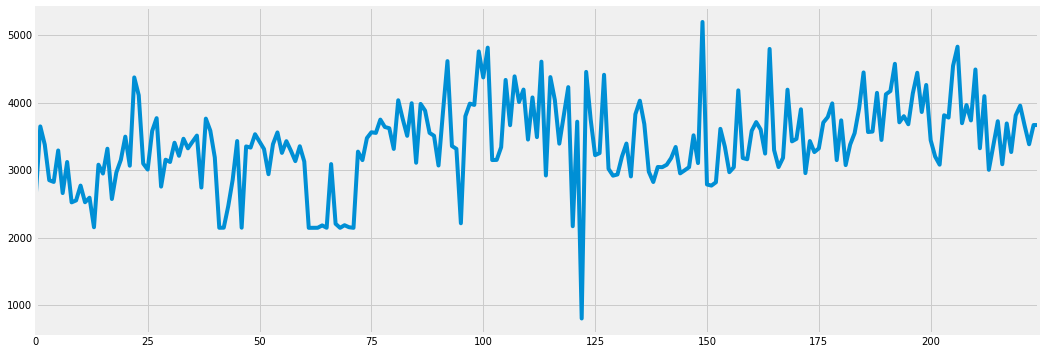

In [64]:
plt.figure(figsize=(16,6))
sns.tsplot(ddf.y)

In [65]:
ddf['cap'] = 6666
ddf['floor'] = 1000

m = Prophet(daily_seasonality=True, growth='logistic', changepoint_range=0.9)
m.fit(ddf)

future = m.make_future_dataframe(periods=60)
future['cap'] = 6666
future['floor'] = 1000
print(future.head())
print(future.tail())
print(ddf.tail())

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


          ds   cap  floor
0 2018-04-26  6666   1000
1 2018-04-27  6666   1000
2 2018-04-28  6666   1000
3 2018-04-29  6666   1000
4 2018-04-30  6666   1000
            ds   cap  floor
280 2019-01-31  6666   1000
281 2019-02-01  6666   1000
282 2019-02-02  6666   1000
283 2019-02-03  6666   1000
284 2019-02-04  6666   1000
            ds       y   cap  floor
220 2018-12-02  3957.0  6666   1000
221 2018-12-03  3660.0  6666   1000
222 2018-12-04  3384.0  6666   1000
223 2018-12-05  3670.0  6666   1000
224 2018-12-06  3669.0  6666   1000


In [66]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
280,2019-01-31,4091.393855,3353.591879,4803.542796
281,2019-02-01,4139.464815,3502.358474,4895.889809
282,2019-02-02,4224.647297,3475.122216,4917.308709
283,2019-02-03,4224.011219,3518.831760,4956.257313
284,2019-02-04,3931.238805,3171.266390,4649.553270


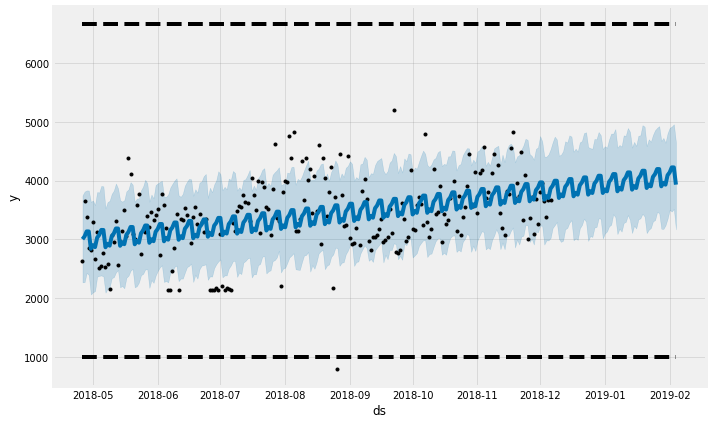

In [67]:
fig1 = m.plot(forecast)

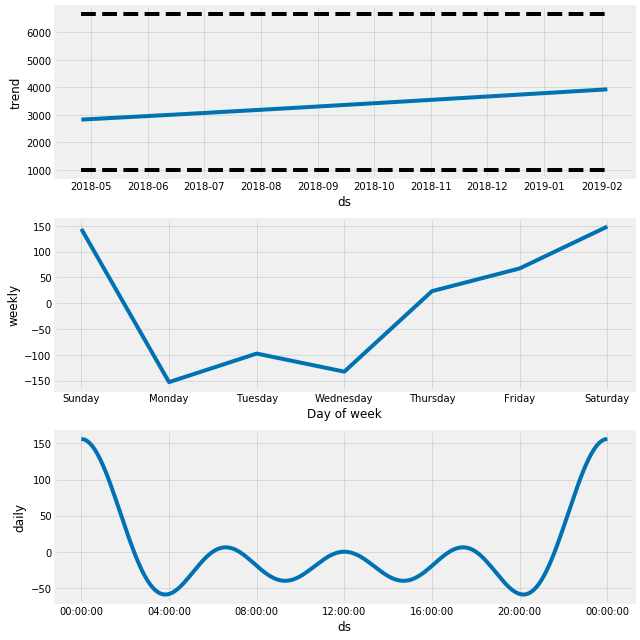

In [68]:
fig2 = m.plot_components(forecast)

In [69]:
# cross_validation(m, initial = 730, period = 180, horizon = 365, units = 'days')
ddf_cv = cross_validation(m, horizon='15 days')
ddf_p = performance_metrics(ddf_cv)
ddf_p.head(10)

INFO:fbprophet:Making 22 forecasts with cutoffs between 2018-06-16 12:00:00 and 2018-11-21 00:00:00


,horizon,mse,rmse,mae,mape,coverage
31,1 days 12:00:00,388851.824591,623.579846,507.270790,0.160534,0.757576
316,2 days 00:00:00,390531.255920,624.925000,508.715436,0.160303,0.757576
196,2 days 00:00:00,394913.336033,628.421305,511.593112,0.163978,0.727273
136,2 days 00:00:00,375993.131944,613.182788,492.282443,0.159229,0.757576
76,2 days 00:00:00,378949.163601,615.588469,494.816941,0.158580,0.757576
106,2 days 00:00:00,377100.386836,614.085000,488.497441,0.156752,0.757576
166,2 days 00:00:00,358763.451038,598.968656,465.334730,0.146167,0.787879
46,2 days 00:00:00,375995.882114,613.185031,478.044963,0.149133,0.757576
16,2 days 00:00:00,440020.112370,663.340118,511.096438,0.166497,0.727273
226,2 days 00:00:00,436751.937138,660.872103,508.057511,0.166610,0.727273


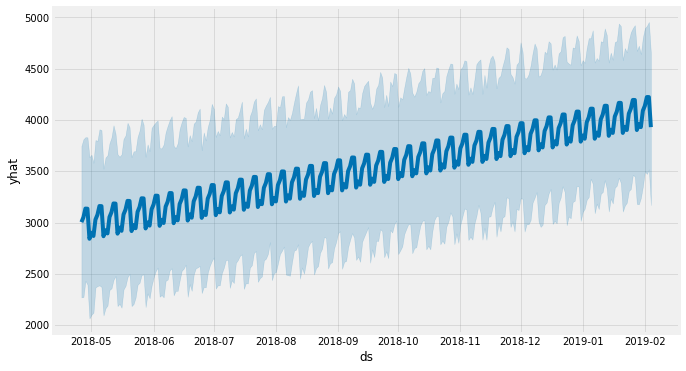

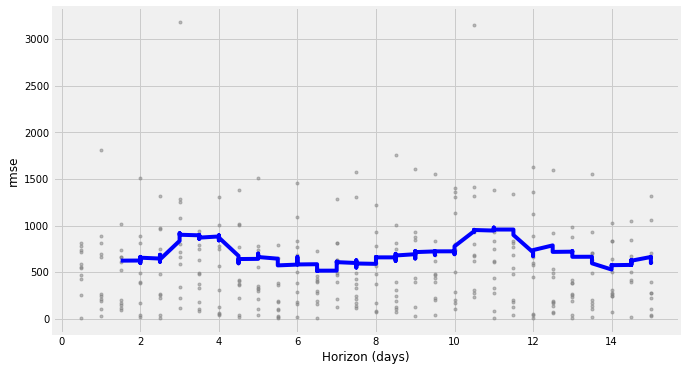

In [70]:
plot_forecast_component(m, forecast, 'yhat')

fig3 = plot_cross_validation_metric(ddf_cv, metric='rmse')

In [71]:
df.head()

,Date,calories_burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
0,2018-04-26,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0
1,2018-04-27,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0
2,2018-04-28,3379.0,3521.0,1.66,2.0,702.0,155.0,22.0,11.0,1124.0
3,2018-04-29,2851.0,1639.0,0.77,0.0,891.0,122.0,0.0,0.0,602.0
4,2018-04-30,2825.0,1323.0,0.62,0.0,880.0,104.0,0.0,0.0,540.0


## 2. ARIMA Model

In [72]:
df = df.set_index('Date')

In [73]:
df.head()

,calories_burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
Date,,,,,,,,,
2018-04-26,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0
2018-04-27,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0
2018-04-28,3379.0,3521.0,1.66,2.0,702.0,155.0,22.0,11.0,1124.0
2018-04-29,2851.0,1639.0,0.77,0.0,891.0,122.0,0.0,0.0,602.0
2018-04-30,2825.0,1323.0,0.62,0.0,880.0,104.0,0.0,0.0,540.0


In [74]:
from statsmodels.tsa.stattools import adfuller
def test_stationary(timeseries):
    #Determine rolling statistics
    rolmean = timeseries.rolling(24).mean()
    rolstd = timeseries.rolling(24).std()
    
    #Plot rolling Statistics
    orig = plt.plot(timeseries, color = "blue", label = "Original")
    mean = plt.plot(rolmean, color = "red", label = "Rolling Mean")
    std = plt.plot(rolstd, color = "black", label = "Rolling Std")
    plt.legend(loc = "best")
    plt.title("Rolling Mean and Standard Deviation")
    plt.show(block = False)
    
    #Perform Dickey Fuller test
    print("Results of Dickey Fuller test: ")
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistics', 'p-value', '# Lag Used', 'Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)

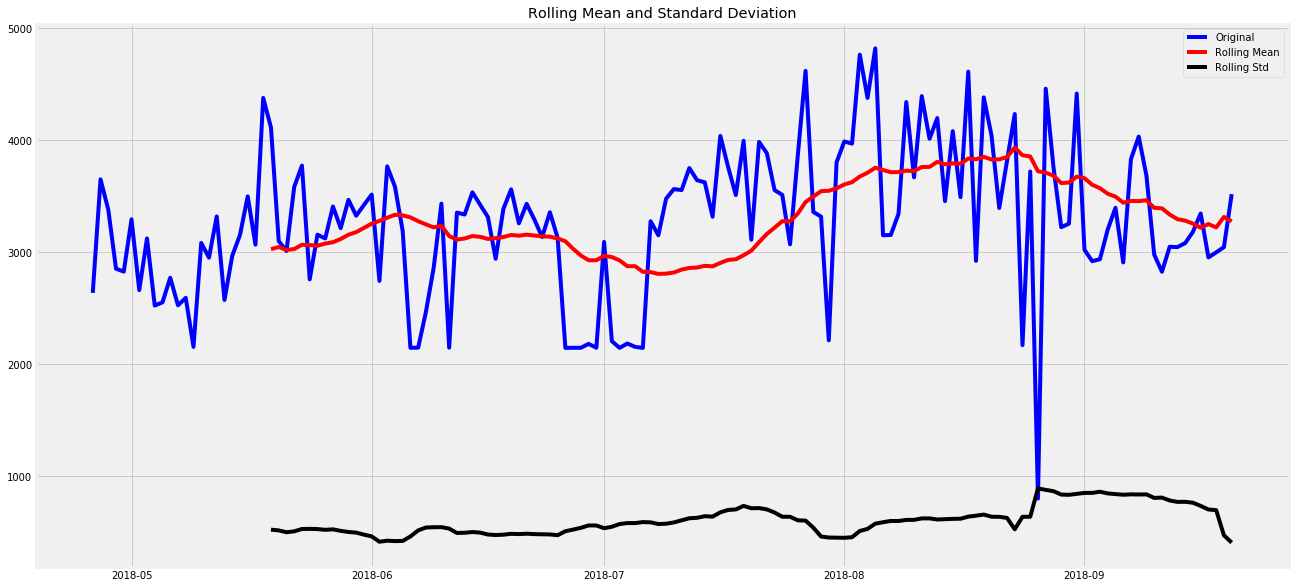

Results of Dickey Fuller test: 
Test Statistics                 -4.796376
p-value                          0.000055
# Lag Used                       1.000000
Number of Observations Used    146.000000
Critical Value (1%)             -3.475953
Critical Value (5%)             -2.881548
Critical Value (10%)            -2.577439
dtype: float64


In [75]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=(20,10)
test_stationary(train_1)

In [76]:
df.calories_burned.tail(141)

Date
2018-07-19    3993.0
2018-07-20    3110.0
2018-07-21    3983.0
2018-07-22    3883.0
2018-07-23    3553.0
2018-07-24    3510.0
2018-07-25    3069.0
2018-07-26    3864.0
2018-07-27    4618.0
2018-07-28    3358.0
2018-07-29    3316.0
2018-07-30    2212.0
2018-07-31    3800.0
2018-08-01    3987.0
2018-08-02    3968.0
2018-08-03    4762.0
2018-08-04    4376.0
2018-08-05    4818.0
2018-08-06    3150.0
2018-08-07    3152.0
2018-08-08    3341.0
2018-08-09    4339.0
2018-08-10    3667.0
2018-08-11    4392.0
2018-08-12    4011.0
2018-08-13    4196.0
2018-08-14    3454.0
2018-08-15    4079.0
2018-08-16    3490.0
2018-08-17    4610.0
               ...  
2018-11-07    3681.0
2018-11-08    4137.0
2018-11-09    4445.0
2018-11-10    3863.0
2018-11-11    4264.0
2018-11-12    3444.0
2018-11-13    3202.0
2018-11-14    3081.0
2018-11-15    3815.0
2018-11-16    3780.0
2018-11-17    4548.0
2018-11-18    4832.0
2018-11-19    3697.0
2018-11-20    3966.0
2018-11-21    3738.0
2018-11-22    4494.0
2018-11-

### Remove Trend

In [77]:
train_log = np.log(train_1)
test_log = np.log(test_1)

In [78]:
train_log.tail(60)

Date
2018-07-23    8.175548
2018-07-24    8.163371
2018-07-25    8.029107
2018-07-26    8.259458
2018-07-27    8.437717
2018-07-28    8.119101
2018-07-29    8.106515
2018-07-30    7.701652
2018-07-31    8.242756
2018-08-01    8.290794
2018-08-02    8.286017
2018-08-03    8.468423
2018-08-04    8.383890
2018-08-05    8.480114
2018-08-06    8.055158
2018-08-07    8.055792
2018-08-08    8.114025
2018-08-09    8.375399
2018-08-10    8.207129
2018-08-11    8.387540
2018-08-12    8.296796
2018-08-13    8.341887
2018-08-14    8.147288
2018-08-15    8.313607
2018-08-16    8.157657
2018-08-17    8.435983
2018-08-18    7.979681
2018-08-19    8.385032
2018-08-20    8.304247
2018-08-21    8.129470
2018-08-22    8.245647
2018-08-23    8.350430
2018-08-24    7.681560
2018-08-25    8.221210
2018-08-26    6.683361
2018-08-27    8.402456
2018-08-28    8.231376
2018-08-29    8.077758
2018-08-30    8.087333
2018-08-31    8.392763
2018-09-01    8.013012
2018-09-02    7.978654
2018-09-03    7.984803
2018-0

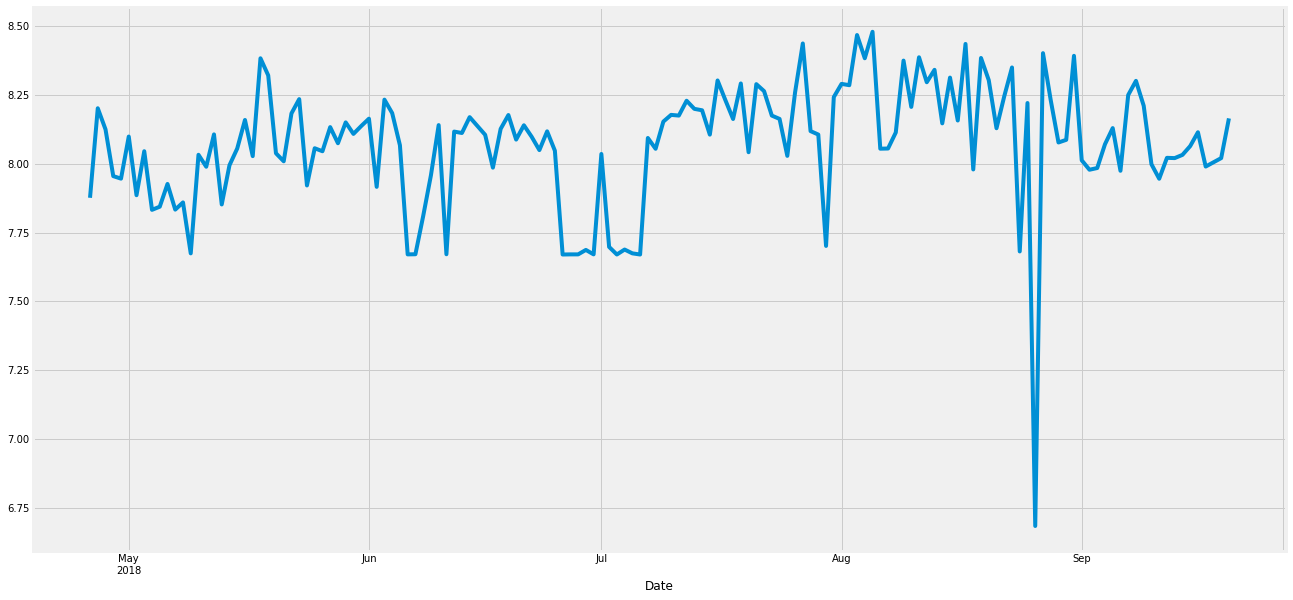

In [79]:
train_log.plot()

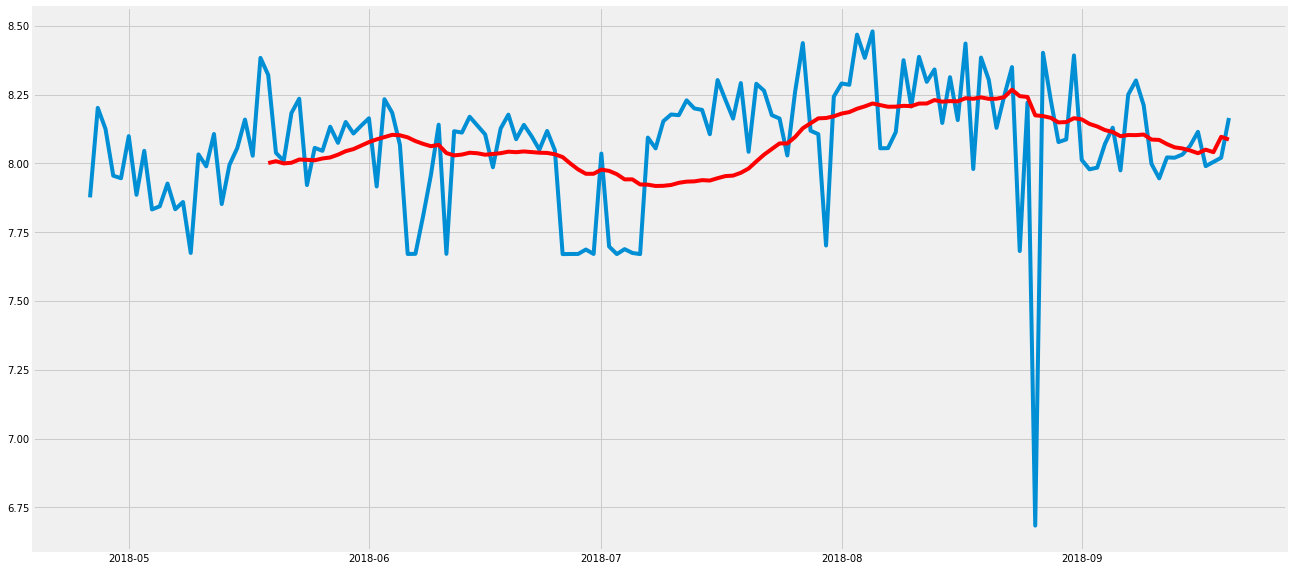

In [80]:
moving_avg = train_log.rolling(24).mean()
plt.plot(train_log)
plt.plot(moving_avg, color = 'red')

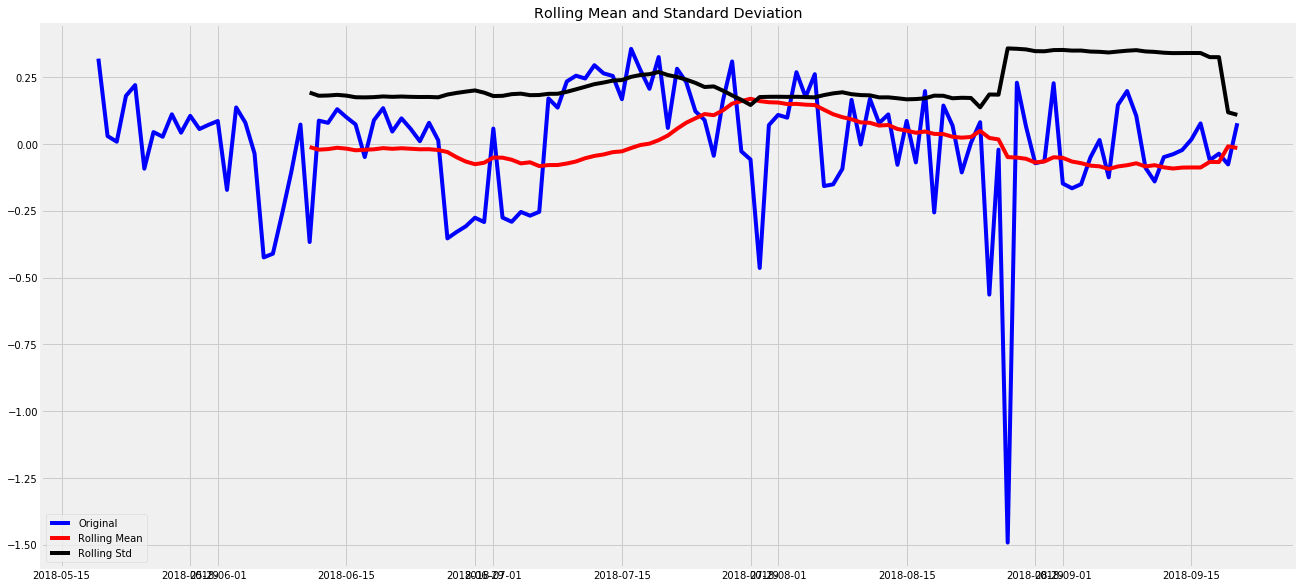

Results of Dickey Fuller test: 
Test Statistics                 -4.967095
p-value                          0.000026
# Lag Used                       1.000000
Number of Observations Used    123.000000
Critical Value (1%)             -3.484667
Critical Value (5%)             -2.885340
Critical Value (10%)            -2.579463
dtype: float64


In [81]:

train_log_moving_diff = train_log - moving_avg
train_log_moving_diff.dropna(inplace = True)
test_stationary(train_log_moving_diff)

### Differencing can help to make series stable and eliminate trend


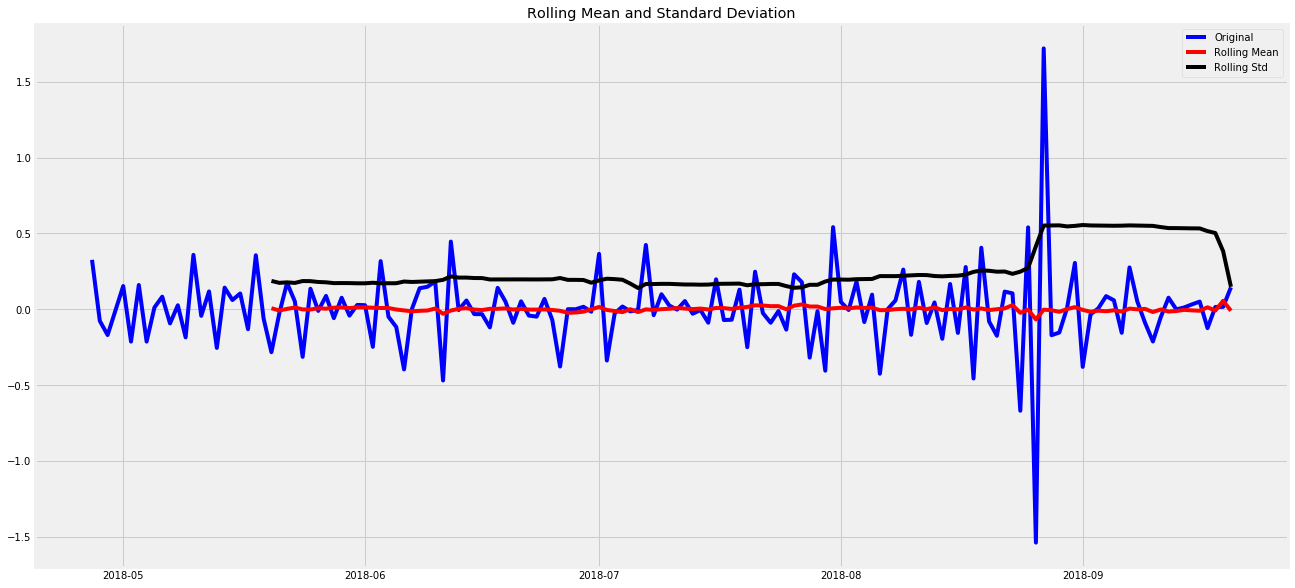

Results of Dickey Fuller test: 
Test Statistics               -7.317233e+00
p-value                        1.220249e-10
# Lag Used                     6.000000e+00
Number of Observations Used    1.400000e+02
Critical Value (1%)           -3.477945e+00
Critical Value (5%)           -2.882416e+00
Critical Value (10%)          -2.577902e+00
dtype: float64


In [82]:
train_log_diff = train_log - train_log.shift(1)
test_stationary(train_log_diff.dropna())

### Removing Seasonailty

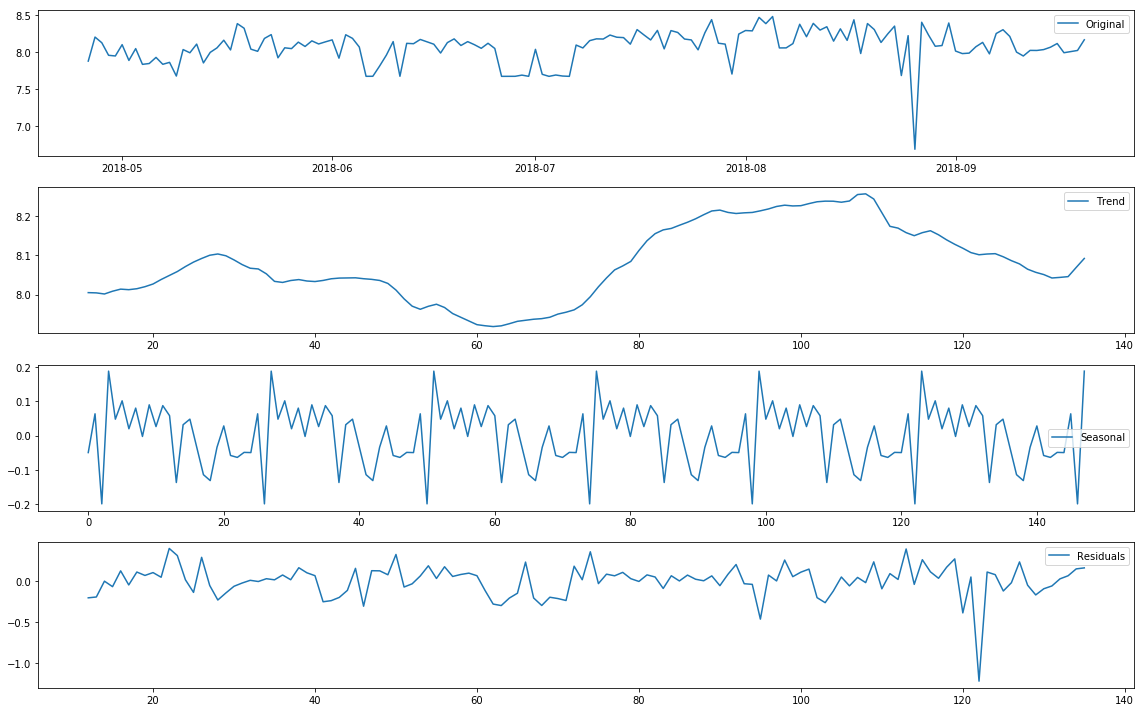

In [83]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize = (16,10))
decomposition = seasonal_decompose(pd.DataFrame(train_log).calories_burned.values, freq = 24)
plt.style.use('default')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(train_log, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

### Let's check stationarity of residuals

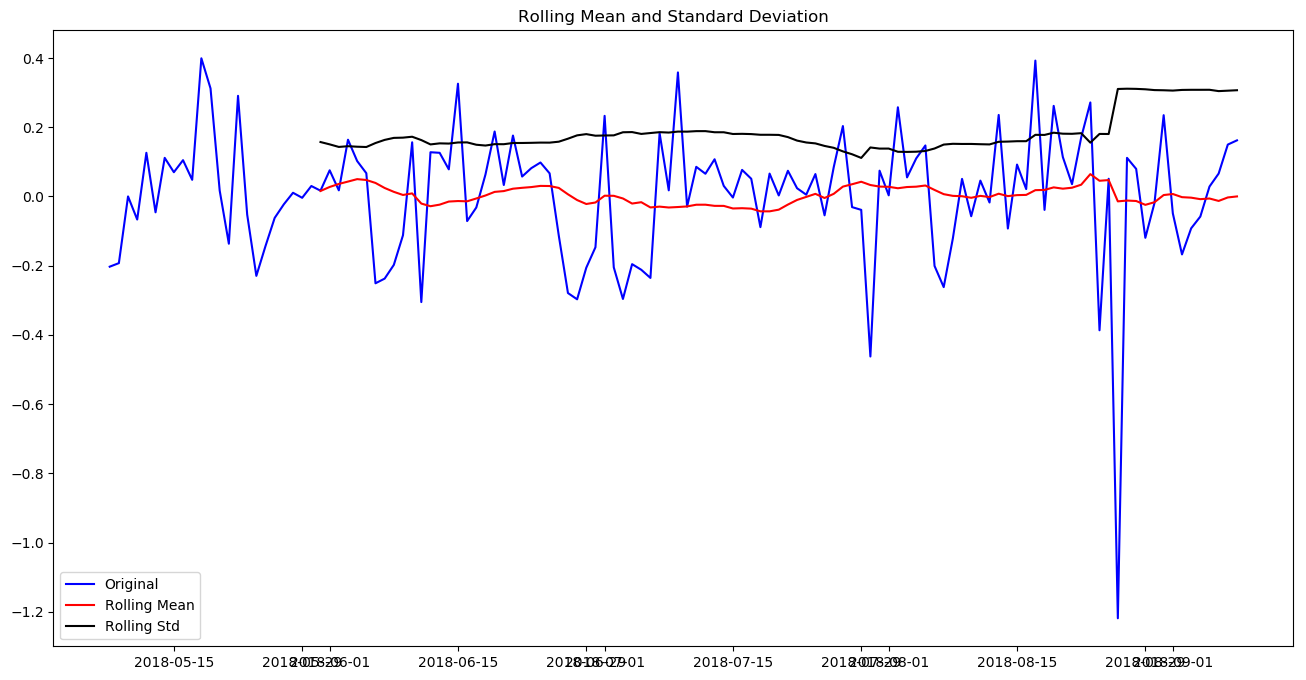

Results of Dickey Fuller test: 
Test Statistics               -6.156501e+00
p-value                        7.346810e-08
# Lag Used                     1.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [84]:
plt.figure(figsize = (16,8))
train_log_decompose = pd.DataFrame(residual)
train_log_decompose['date'] = train_log.index
train_log_decompose.set_index('date', inplace = True)
train_log_decompose.dropna(inplace = True)
test_stationary(train_log_decompose[0])

In [85]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(train_log_diff.dropna(), nlags = 25)
lag_pacf = pacf(train_log_diff.dropna(), nlags = 25, method= "ols")

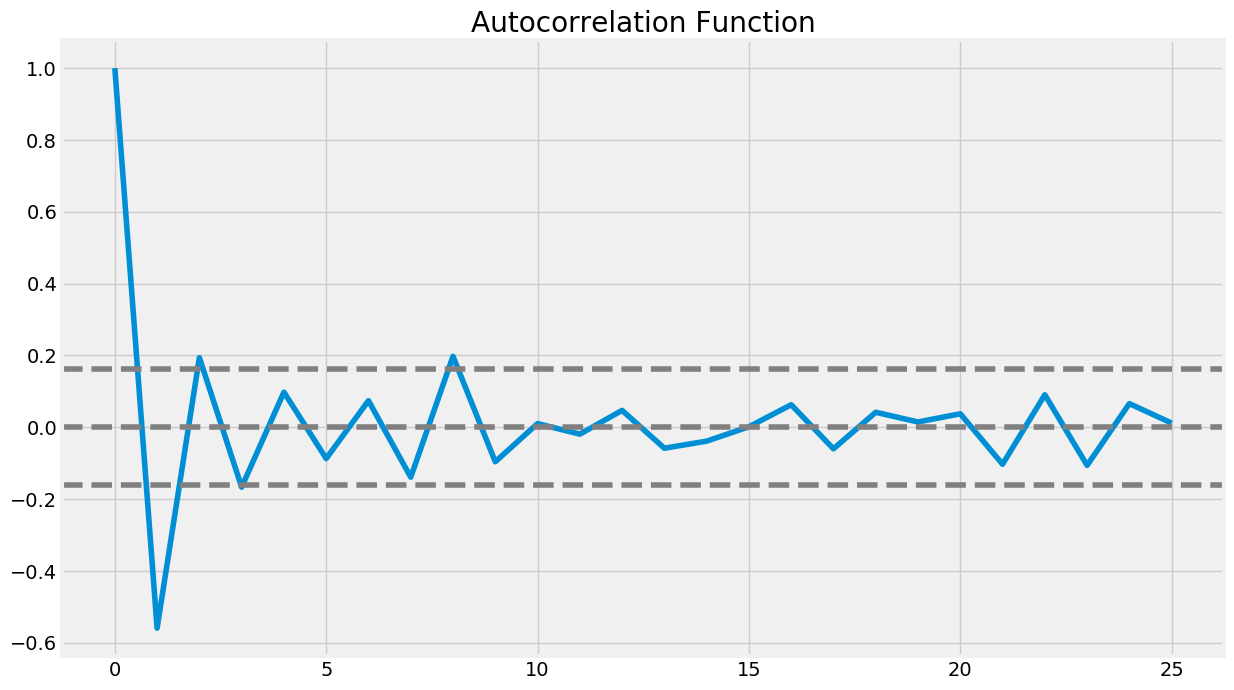

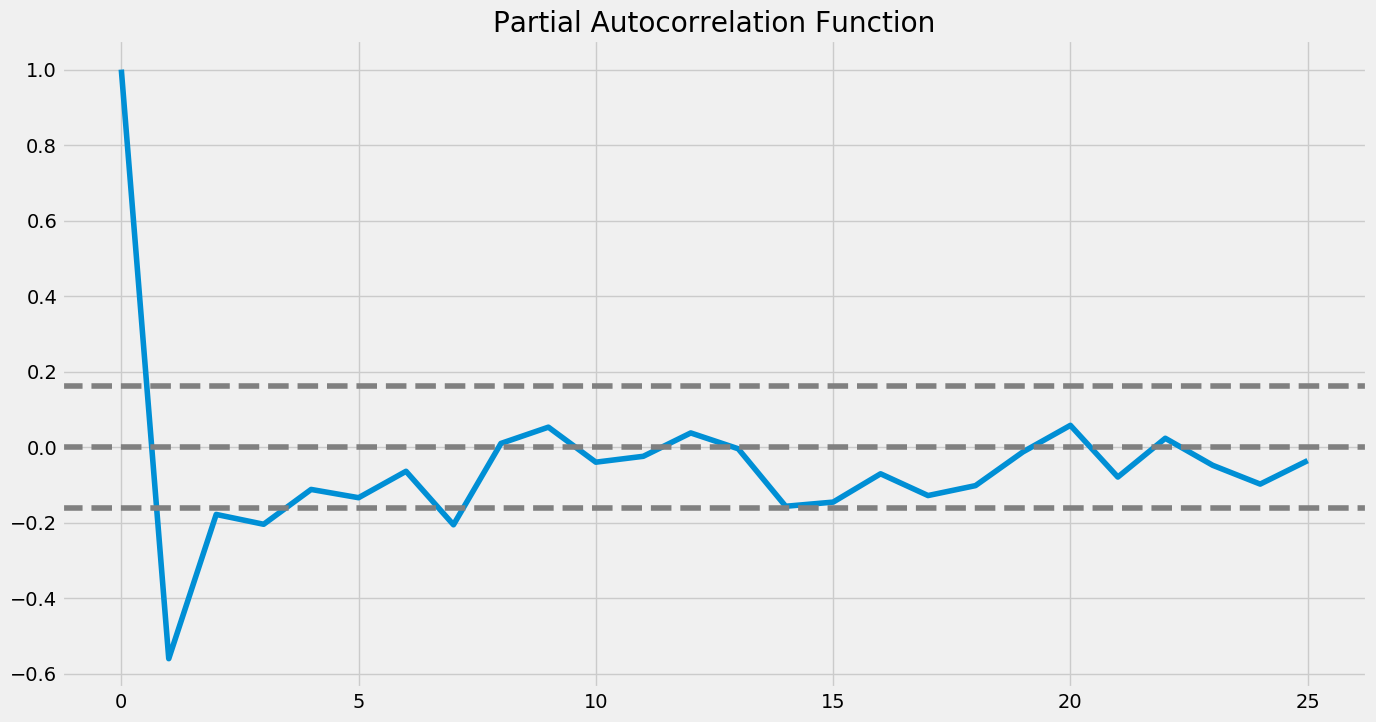

In [86]:

plt.figure(figsize = (15,8))
plt.style.use("fivethirtyeight")
plt.plot(lag_acf)
plt.axhline( y = 0, linestyle = "--", color = "gray")
plt.axhline( y= -1.96/np.sqrt(len(train_log_diff.dropna())), linestyle = "--", color = "gray")
plt.axhline(y = 1.96 /np.sqrt(len(train_log_diff.dropna())), linestyle = "--", color = "gray")
plt.title("Autocorrelation Function")
plt.show()
# PACF
plt.figure(figsize = (15,8))
plt.plot(lag_pacf)
plt.axhline(y = 0, linestyle = "--", color = "gray")
plt.axhline(y = -1.96/np.sqrt(len(train_log_diff.dropna())), linestyle = "--", color = "gray")
plt.axhline( y = 1.96/np.sqrt(len(train_log_diff.dropna())), linestyle = "--", color = "gray")
plt.title("Partial Autocorrelation Function")
plt.show()

### AR Model

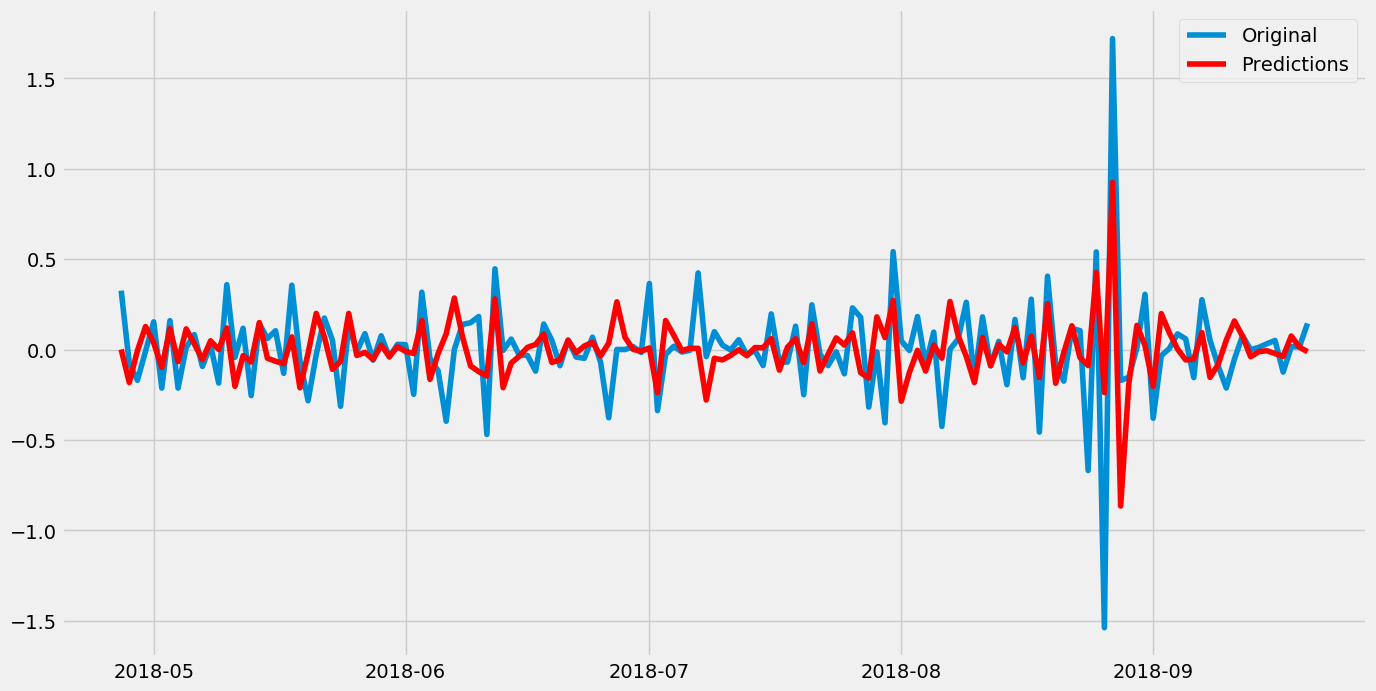

In [87]:
from statsmodels.tsa.arima_model import ARIMA
plt.figure(figsize = (15,8))
model = ARIMA(train_log, order = (2,1,0))  #here q value is zero since it is just AR Model
results_AR = model.fit(disp=-1)
plt.plot(train_log_diff.dropna(), label = "Original")
plt.plot(results_AR.fittedvalues, color = 'red', label = 'Predictions')
plt.legend(loc = 'best')

In [88]:
train_log

Date
2018-04-26    7.876638
2018-04-27    8.202208
2018-04-28    8.125335
2018-04-29    7.955425
2018-04-30    7.946264
2018-05-01    8.099251
2018-05-02    7.886081
2018-05-03    8.045909
2018-05-04    7.832808
2018-05-05    7.844241
2018-05-06    7.926964
2018-05-07    7.833600
2018-05-08    7.859799
2018-05-09    7.674617
2018-05-10    8.033009
2018-05-11    7.989560
2018-05-12    8.107117
2018-05-13    7.852439
2018-05-14    7.994970
2018-05-15    8.055792
2018-05-16    8.159661
2018-05-17    8.028129
2018-05-18    8.383890
2018-05-19    8.321665
2018-05-20    8.038512
2018-05-21    8.009363
2018-05-22    8.183397
2018-05-23    8.235361
2018-05-24    7.921536
2018-05-25    8.056744
                ...   
2018-08-22    8.245647
2018-08-23    8.350430
2018-08-24    7.681560
2018-08-25    8.221210
2018-08-26    6.683361
2018-08-27    8.402456
2018-08-28    8.231376
2018-08-29    8.077758
2018-08-30    8.087333
2018-08-31    8.392763
2018-09-01    8.013012
2018-09-02    7.978654
2018-0

In [89]:
test_log

Date
2018-09-21    8.040769
2018-09-22    8.556222
2018-09-23    7.932721
2018-09-24    7.926964
2018-09-25    7.944492
2018-09-26    8.192294
2018-09-27    8.116118
2018-09-28    7.996317
2018-09-29    8.020599
2018-09-30    8.339023
2018-10-01    8.064636
2018-10-02    8.058960
2018-10-03    8.184235
2018-10-04    8.219595
2018-10-05    8.189522
2018-10-06    8.085179
2018-10-07    8.476163
2018-10-08    8.101375
2018-10-09    8.021585
2018-10-10    8.065579
2018-10-11    8.341410
2018-10-12    8.139441
2018-10-13    8.150179
2018-10-14    8.269501
2018-10-15    7.991592
2018-10-16    8.140898
2018-10-17    8.091933
2018-10-18    8.108623
2018-10-19    8.217708
2018-10-20    8.239593
                ...   
2018-11-07    8.210940
2018-11-08    8.327726
2018-11-09    8.399535
2018-11-10    8.259199
2018-11-11    8.357963
2018-11-12    8.144389
2018-11-13    8.071531
2018-11-14    8.033009
2018-11-15    8.246696
2018-11-16    8.237479
2018-11-17    8.422443
2018-11-18    8.483016
2018-1

In [90]:
AR_predict = results_AR.predict(start='2018-09-21', end='2018-12-06')
AR_predict = AR_predict.cumsum().shift().fillna(0)
AR_predict1 = pd.Series(np.ones(test.shape[0])* np.log(test['calories_burned'])[0], index = test.index)
AR_predict1=AR_predict1.add(AR_predict,fill_value=0)
AR_predict = np.exp(AR_predict1)

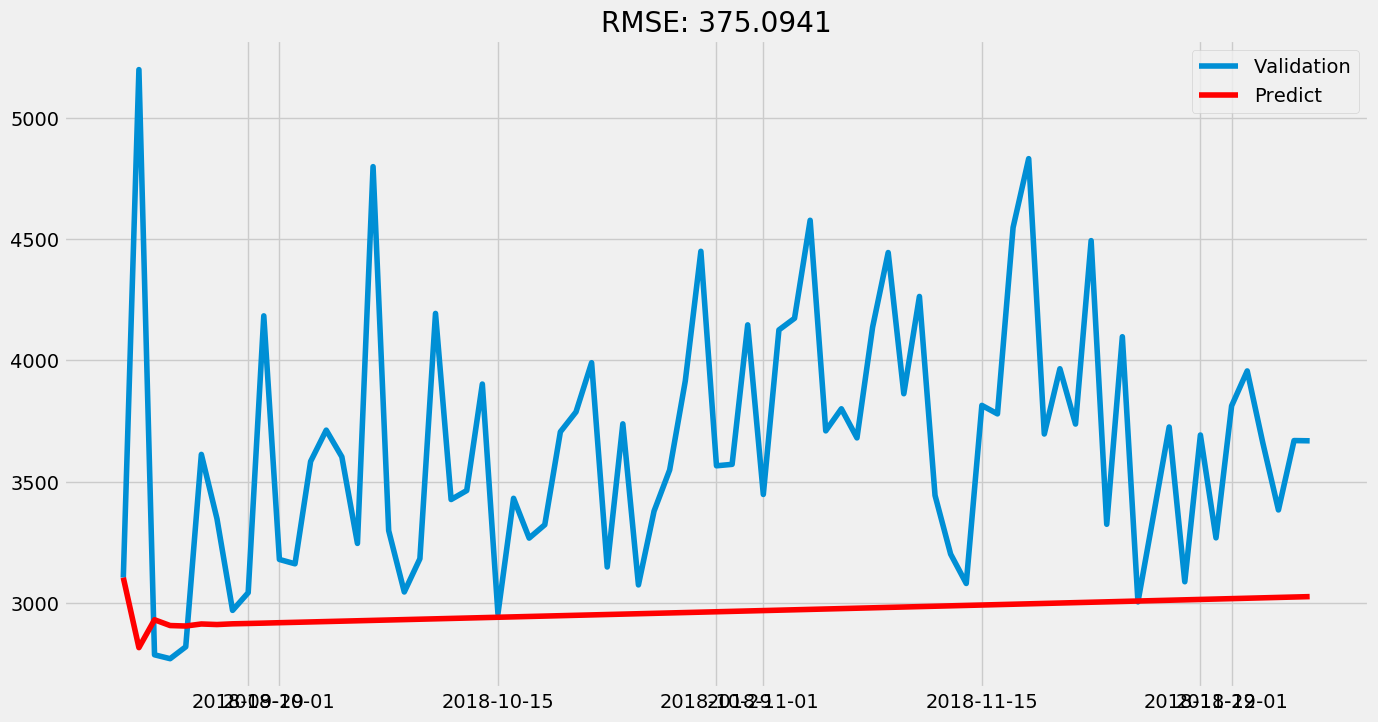

In [91]:
plt.figure(figsize = (15,8))
plt.plot(test, label = "Validation")
plt.plot(AR_predict, color = "red", label = "Predict")
plt.legend(loc = "best")
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(AR_predict, test))/test.shape[0]))
plt.show()

### Moving Average Model

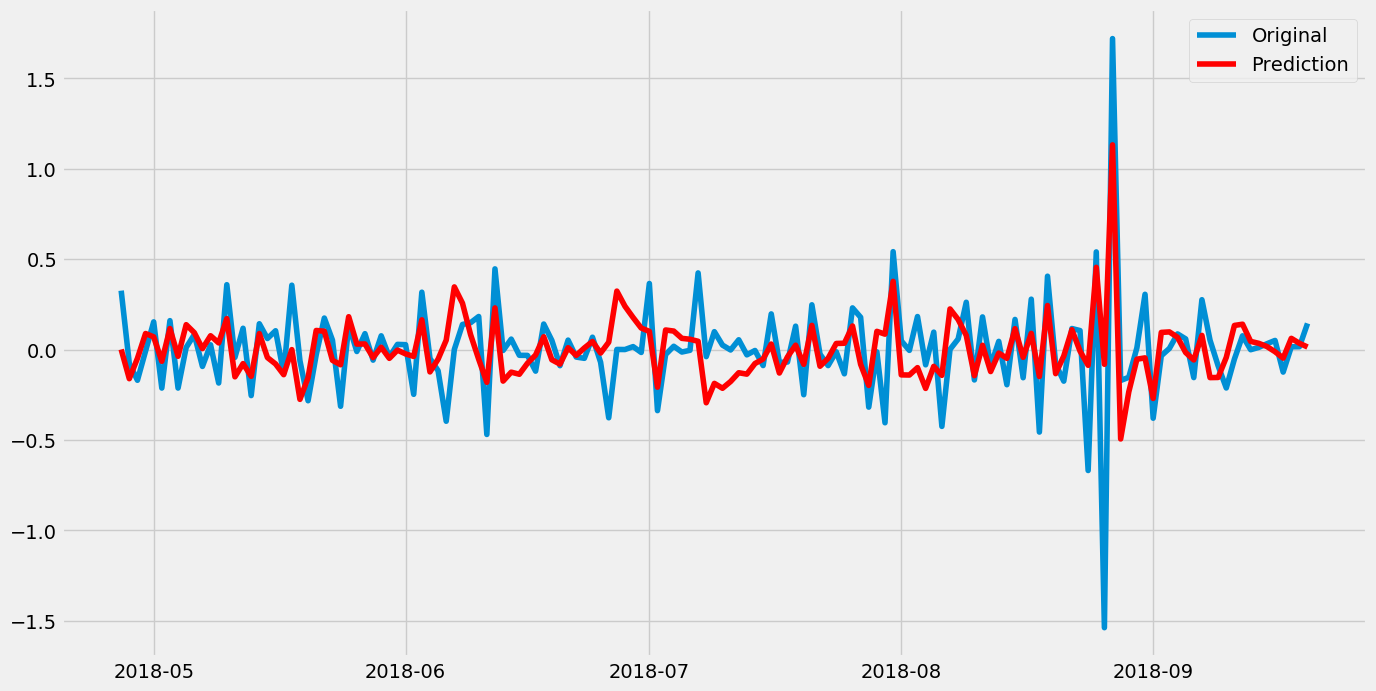

In [92]:
plt.figure(figsize = (15,8))
model = ARIMA(train_log, order = (0,1,2)) # here the p value is 0 since it is moving average model
results_MA = model.fit(disp = -1)
plt.plot(train_log_diff.dropna(), label = "Original")
plt.plot(results_MA.fittedvalues, color = "red", label = "Prediction")
plt.legend(loc = "best")

In [93]:
MA_predict = results_MA.predict(start='2018-09-21', end='2018-12-06')
MA_predict=MA_predict.cumsum().shift().fillna(0)
MA_predict1=pd.Series(np.ones(test.shape[0]) * np.log(test['calories_burned']), index = test.index)
MA_predict1=MA_predict1.add(MA_predict,fill_value=0)
MA_predict = np.exp(MA_predict1)


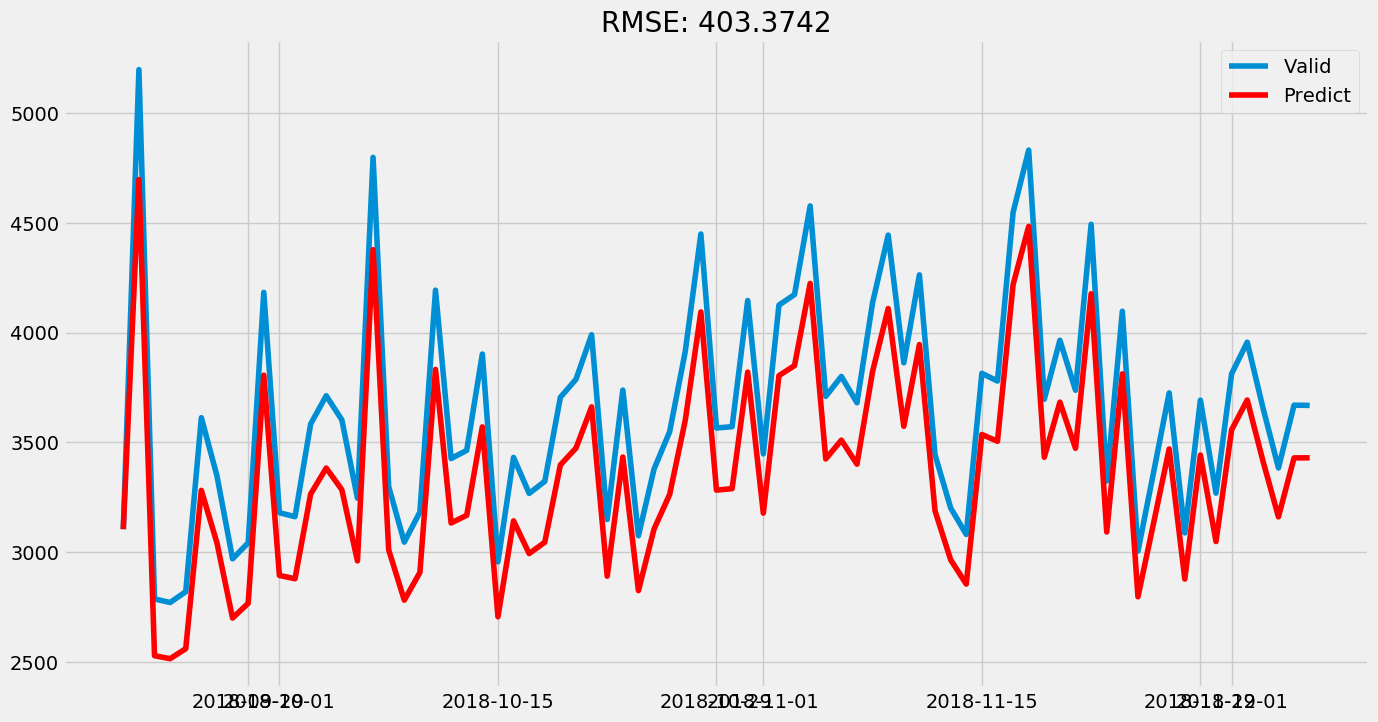

In [94]:
plt.figure(figsize = (15,8))
plt.plot(test, label = "Valid")
plt.plot(MA_predict, color = 'red', label = "Predict")
plt.legend(loc= 'best')
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(MA_predict, test))/test.shape[0]))
plt.show()

### Combined Model

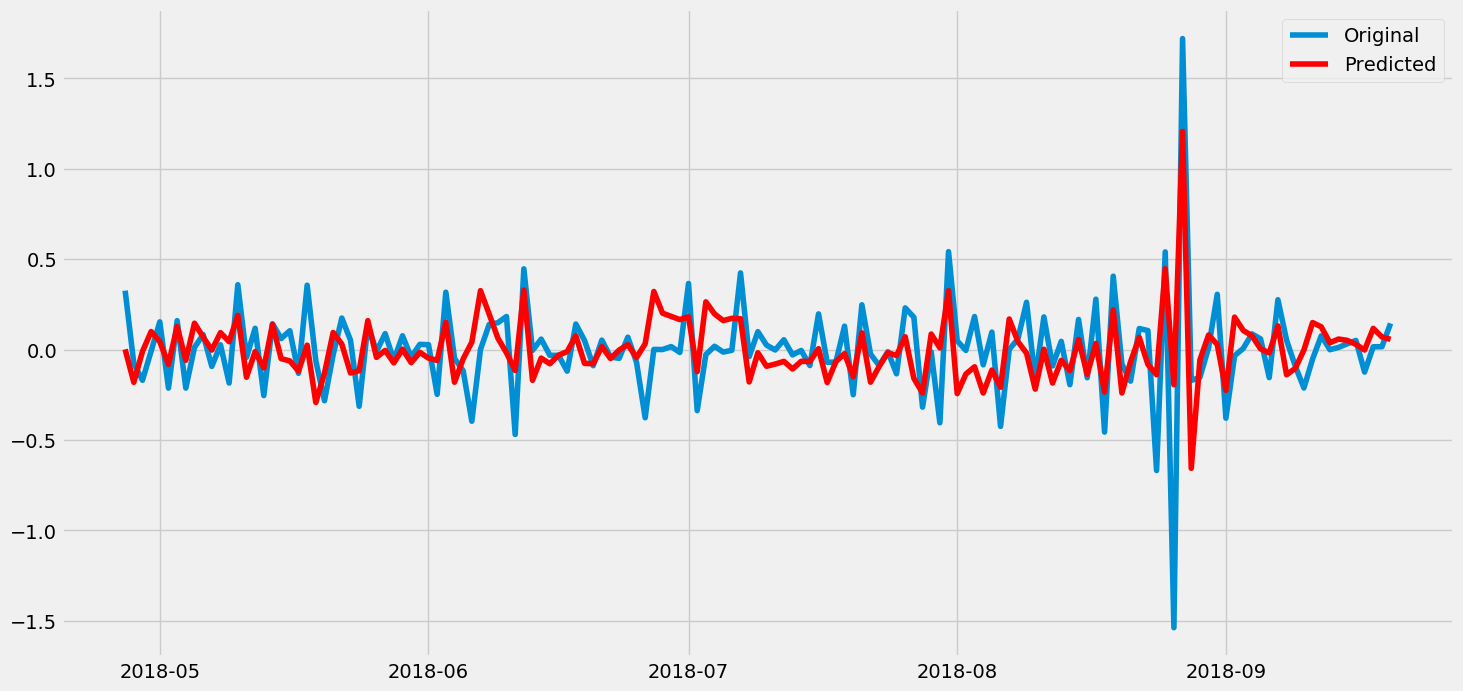

In [95]:
plt.figure(figsize = (16,8))
model = ARIMA(train_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(),  label='Original')
plt.plot(results_ARIMA.fittedvalues, color='red', label='Predicted')
plt.legend(loc='best')
plt.show()

In [96]:
def check_prediction_diff(predict_diff, given_set):
    predict_diff= predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.ones(given_set.shape[0]) * np.log(given_set['calories_burned']), index = given_set.index)
    predict_log = predict_base.add(predict_diff,fill_value=0)
    predict = np.exp(predict_log)
    
    plt.plot(given_set, label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set))/given_set.shape[0]))
    plt.show()

In [97]:
def check_prediction_log(predict_log, given_set):
    predict = np.exp(predict_log)
    
    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))
    plt.show()

In [98]:
ARIMA_predict_diff=results_ARIMA.predict(start='2018-09-21', end='2018-12-06')


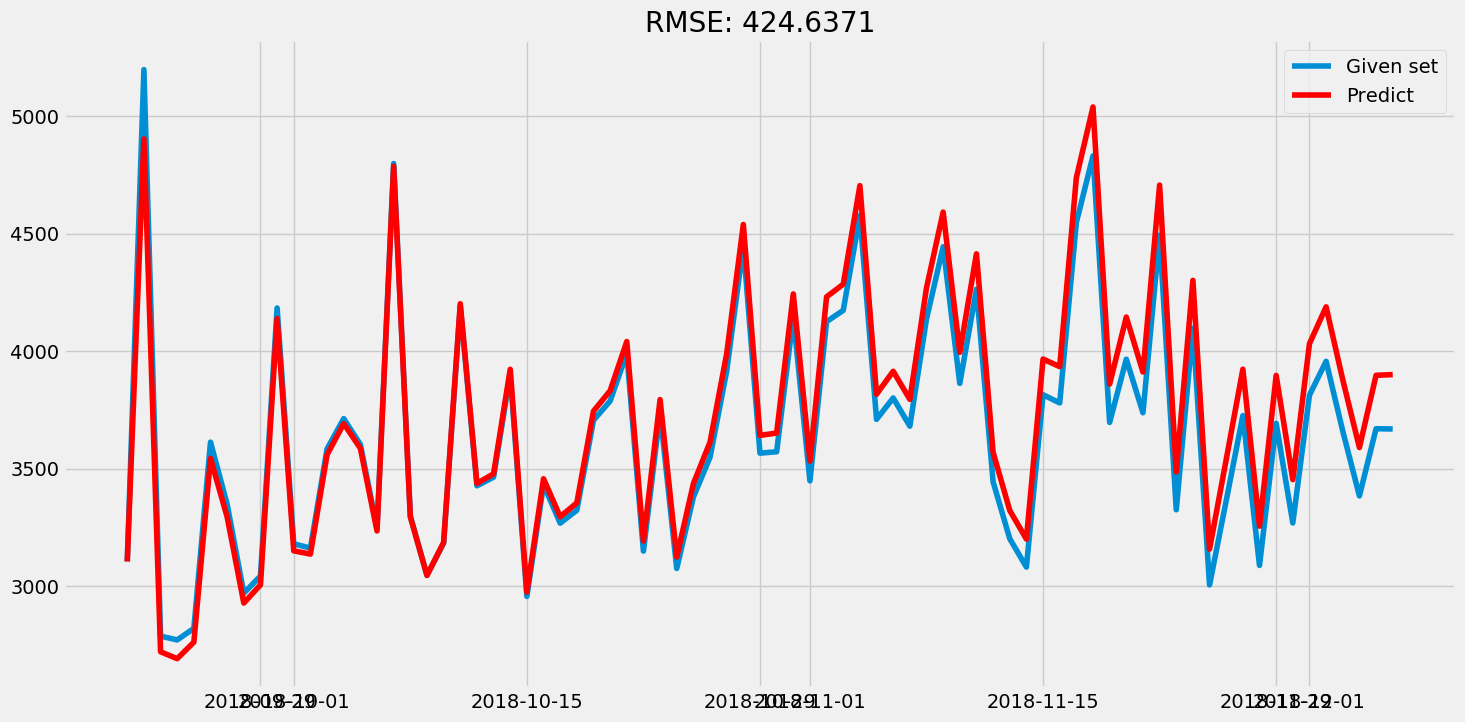

In [99]:
plt.figure(figsize = (16,8))
check_prediction_diff(ARIMA_predict_diff, test)

## 3. SARIMAX Model

In [100]:
import statsmodels.api as sm

Text(0.5, 1.0, 'SARIMAX Model')

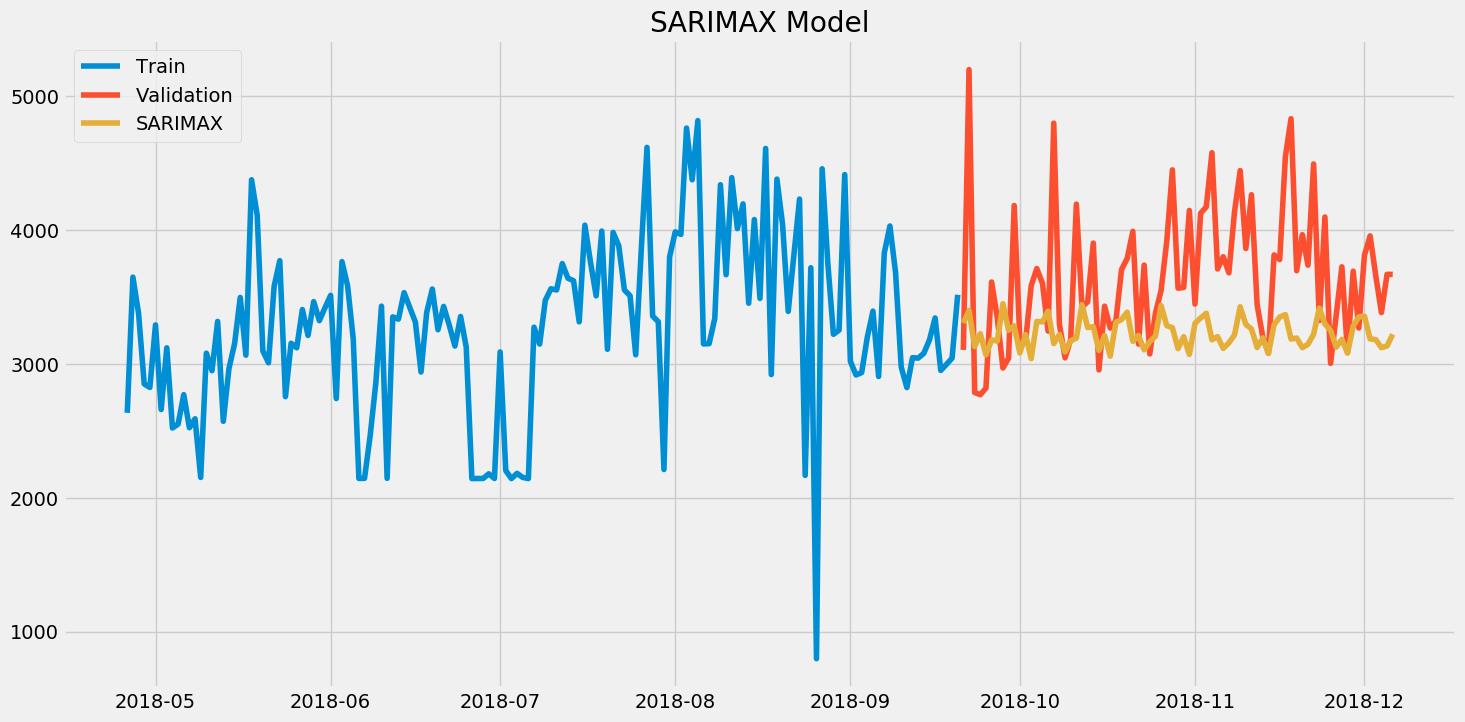

In [101]:
y_hat_avg = test.copy()
fit1 = sm.tsa.statespace.SARIMAX(train, order = (2,1,4), seasonal_order =(0,1,1,7)).fit()
y_hat_avg['SARIMAX'] = fit1.predict(start='2018-09-21', end='2018-12-06', dynamic=True)
plt.figure(figsize=(16,8))
plt.plot(train, label = "Train")
plt.plot(test, label = "Validation")
plt.plot(y_hat_avg['SARIMAX'], label ="SARIMAX")
plt.legend(loc = "best")
plt.title("SARIMAX Model")

In [102]:
y_hat_avg

,calories_burned,SARIMAX
Date,,
2018-09-21,3105.0,3306.327962
2018-09-22,5199.0,3400.216306
2018-09-23,2787.0,3129.506398
2018-09-24,2771.0,3225.963450
2018-09-25,2820.0,3067.842306
2018-09-26,3613.0,3179.990711
2018-09-27,3348.0,3171.539120
2018-09-28,2970.0,3450.406907
2018-09-29,3043.0,3252.028886


In [103]:
def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

### Evaluate Performance of the SARIMAX Model

In [104]:
evaluate(test, y_hat_avg['SARIMAX'])

MSE:  419875.7056115553
RMSE: 647.9781675423604


### Create dataframe for predictions

In [105]:
date_index = pd.date_range(start='2018-12-07', freq='1d', periods=14)

In [106]:
ddf = pd.DataFrame(dict(calories_burned=df['calories_burned'].mean()), index=date_index)

In [107]:
ddf

,calories_burned
2018-12-07,3401.911111
2018-12-08,3401.911111
2018-12-09,3401.911111
2018-12-10,3401.911111
2018-12-11,3401.911111
2018-12-12,3401.911111
2018-12-13,3401.911111
2018-12-14,3401.911111
2018-12-15,3401.911111
2018-12-16,3401.911111


Text(0.5, 1.0, 'SARIMAX Model')

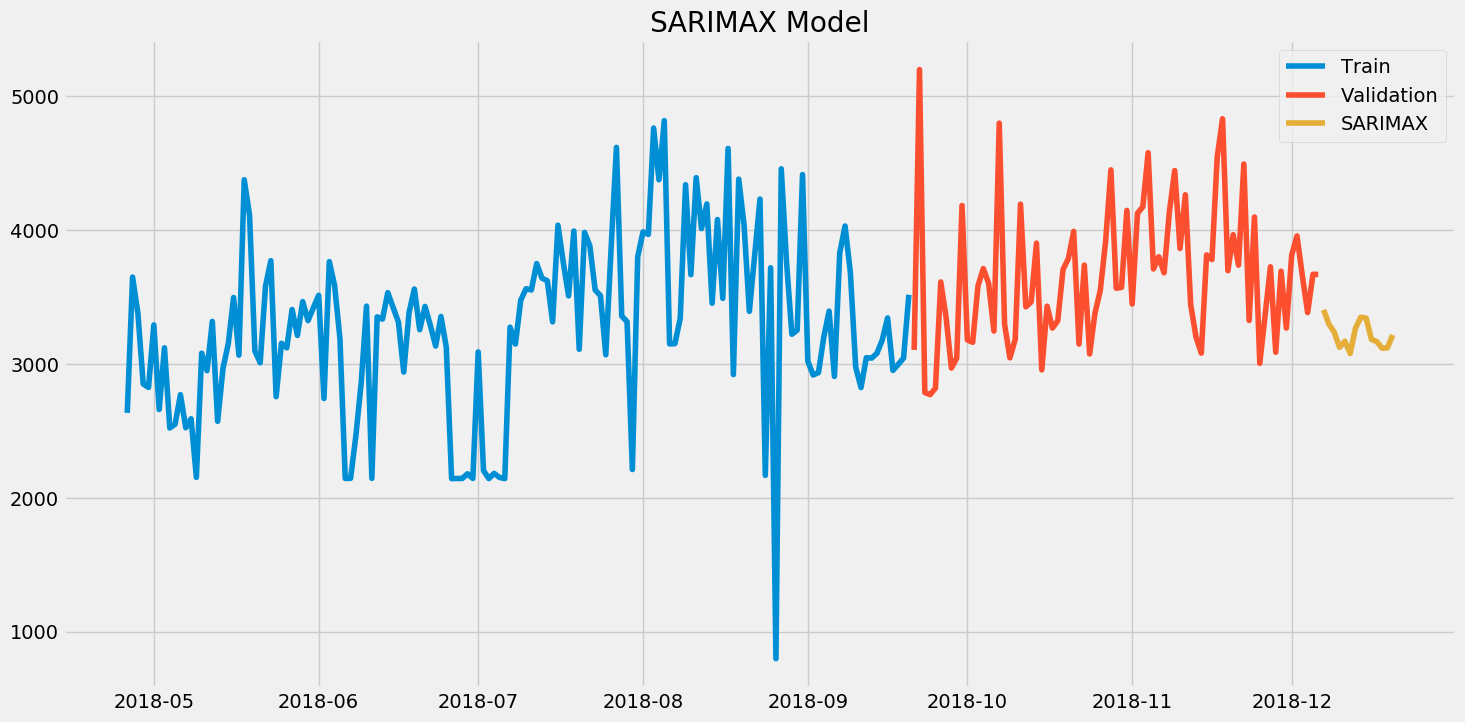

In [108]:
y_hat_avg2 = ddf.copy()
fit1 = sm.tsa.statespace.SARIMAX(train, order = (2,1,4), seasonal_order =(0,1,1,7)).fit()
y_hat_avg2['SARIMAX'] = fit1.predict(start='2018-12-07', end='2018-12-20', dynamic=True)
plt.figure(figsize=(16,8))
plt.plot(train, label = "Train")
plt.plot(test, label = "Validation")
plt.plot(y_hat_avg2['SARIMAX'], label ="SARIMAX")
plt.legend(loc = "best")
plt.title("SARIMAX Model")

In [109]:
y_hat_avg2

,calories_burned,SARIMAX
2018-12-07,3401.911111,3404.266396
2018-12-08,3401.911111,3298.391489
2018-12-09,3401.911111,3237.712416
2018-12-10,3401.911111,3124.462467
2018-12-11,3401.911111,3170.274866
2018-12-12,3401.911111,3078.727861
2018-12-13,3401.911111,3268.288461
2018-12-14,3401.911111,3349.299041
2018-12-15,3401.911111,3343.182721
2018-12-16,3401.911111,3183.951899


### Comparing predictions

In [110]:
y_hat_avg2

,calories_burned,SARIMAX
2018-12-07,3401.911111,3404.266396
2018-12-08,3401.911111,3298.391489
2018-12-09,3401.911111,3237.712416
2018-12-10,3401.911111,3124.462467
2018-12-11,3401.911111,3170.274866
2018-12-12,3401.911111,3078.727861
2018-12-13,3401.911111,3268.288461
2018-12-14,3401.911111,3349.299041
2018-12-15,3401.911111,3343.182721
2018-12-16,3401.911111,3183.951899


In [111]:
# plt.figure(figsize = (16,8))
model = ARIMA(train['calories_burned'], order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
forecast = results_ARIMA.forecast(steps=14)[0]


In [112]:
y_hat_avg2['ARIMA'] = forecast

In [113]:
y_hat_avg2

,calories_burned,SARIMAX,ARIMA
2018-12-07,3401.911111,3404.266396,3230.054135
2018-12-08,3401.911111,3298.391489,3283.664711
2018-12-09,3401.911111,3237.712416,3187.256196
2018-12-10,3401.911111,3124.462467,3261.749171
2018-12-11,3401.911111,3170.274866,3195.789119
2018-12-12,3401.911111,3078.727861,3256.110975
2018-12-13,3401.911111,3268.288461,3205.902295
2018-12-14,3401.911111,3349.299041,3253.200600
2018-12-15,3401.911111,3343.182721,3214.679676
2018-12-16,3401.911111,3183.951899,3251.742539


Text(0.5, 1.0, 'ARIMA vs. SARIMAX Model')

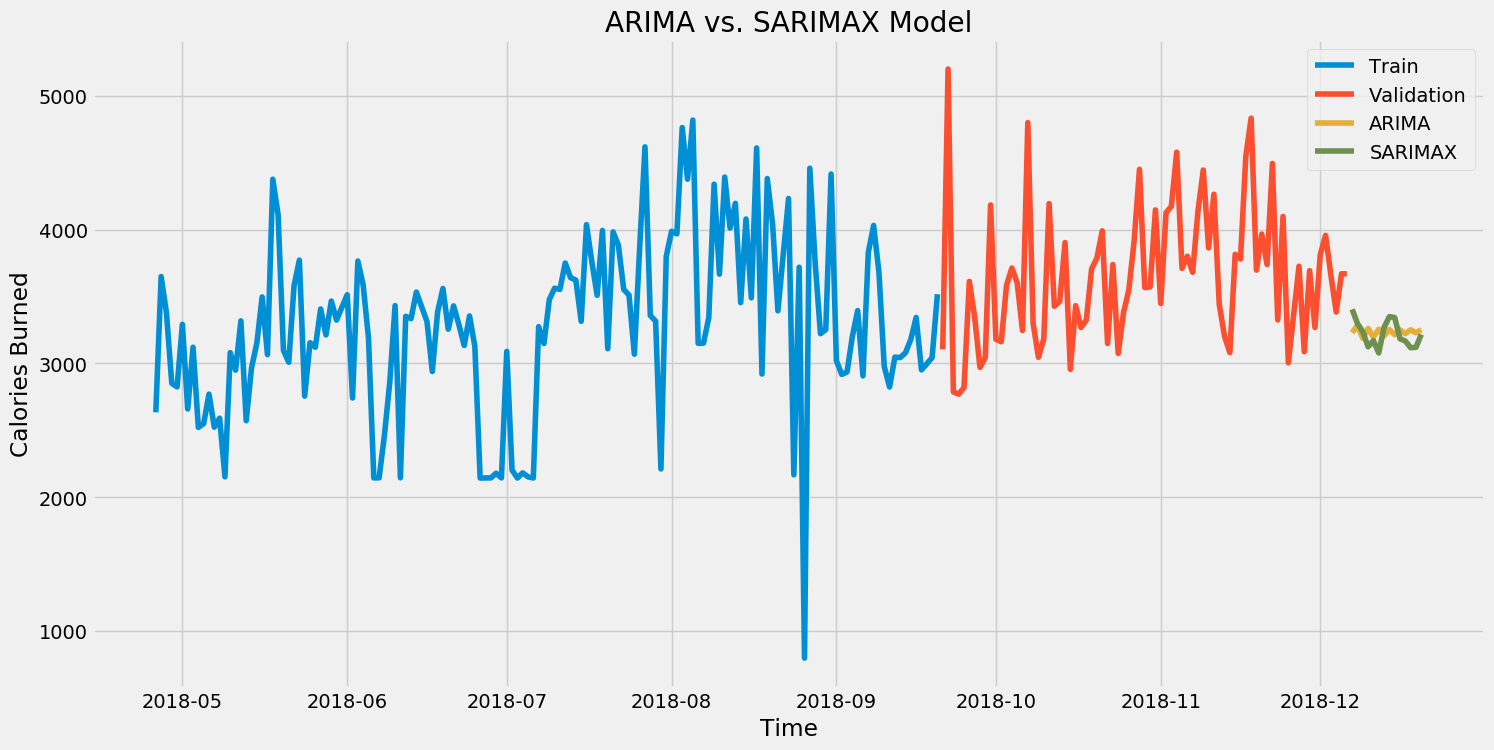

In [114]:
plt.figure(figsize=(16,8))
plt.plot(train, label = "Train")
plt.plot(test, label = "Validation")
plt.plot(y_hat_avg2['ARIMA'], label ="ARIMA")
plt.plot(y_hat_avg2['SARIMAX'], label ="SARIMAX")
plt.legend(loc = "best")
plt.xlabel('Time')
plt.ylabel('Calories Burned')
plt.title("ARIMA vs. SARIMAX Model")

In [115]:
df.head()

,calories_burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
Date,,,,,,,,,
2018-04-26,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0
2018-04-27,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0
2018-04-28,3379.0,3521.0,1.66,2.0,702.0,155.0,22.0,11.0,1124.0
2018-04-29,2851.0,1639.0,0.77,0.0,891.0,122.0,0.0,0.0,602.0
2018-04-30,2825.0,1323.0,0.62,0.0,880.0,104.0,0.0,0.0,540.0


In [116]:
# missing = {'Date': '7/28/18', 'Calories Burned': 3358, 'Steps': 8073, 'Distance': 3.81, 'Floors': 5.0, 'Minutes Sedentary': 674.0, 'Minutes Lightly Active': 236.0, 'Minutes Fairly Active': 19.0, 'Minutes Very Active': 9.0, 'Activity Calories': 1481}

### Making Final Predictions

In [117]:
pdf = pd.DataFrame(dict(calories_burned=''), index=date_index)

In [118]:
pdf

,calories_burned
2018-12-07,
2018-12-08,
2018-12-09,
2018-12-10,
2018-12-11,
2018-12-12,
2018-12-13,
2018-12-14,
2018-12-15,
2018-12-16,


In [119]:
model = ARIMA(train['calories_burned'], order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
forecast = results_ARIMA.forecast(steps=14)[0]
forecast

array([3230.05413451, 3283.66471132, 3187.25619612, 3261.74917125,
       3195.78911882, 3256.11097537, 3205.90229517, 3253.2005997 ,
       3214.679676  , 3251.74253893, 3222.24960129, 3251.3662538 ,
       3228.87170603, 3251.82585541])

In [120]:
aggregation = 'sum'
ts_data = df['Steps'].resample('D').agg(aggregation)
train_size = int(len(ts_data) * 0.66)
train_1, test_1 = ts_data[0:train_size], ts_data[train_size:len(ts_data)]
train = pd.DataFrame(train_1)
test = pd.DataFrame(test_1)
model = ARIMA(train['Steps'], order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
forecast = results_ARIMA.forecast(steps=14)[0]
pdf['Steps'] = forecast

In [121]:
pdf

,calories_burned,Steps
2018-12-07,,8269.220854
2018-12-08,,8747.908729
2018-12-09,,7923.701013
2018-12-10,,8619.145621
2018-12-11,,7961.268015
2018-12-12,,8636.145895
2018-12-13,,8049.364933
2018-12-14,,8675.264244
2018-12-15,,8142.431738
2018-12-16,,8719.320109


In [122]:
for col in df.columns:
    try:
        aggregation = 'sum'
        ts_data = df[col].resample('D').agg(aggregation)
        train_size = int(len(ts_data) * 0.66)
        train_1, test_1 = ts_data[0:train_size], ts_data[train_size:len(ts_data)]
        train = pd.DataFrame(train_1)
        test = pd.DataFrame(test_1)
        model = ARIMA(train[col], order=(2, 1, 2))  
        results_ARIMA = model.fit(disp=-1)  
        forecast = results_ARIMA.forecast(steps=14)[0]
        pdf[col] = forecast
    except:
        pass

In [123]:
pdf

,calories_burned,Steps,Distance,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
2018-12-07,3230.054135,8269.220854,3.898241,770.102354,191.155086,15.331541,33.593369,1351.265765
2018-12-08,3283.664711,8747.908729,4.134846,762.918518,192.530718,14.233880,34.396486,1388.354122
2018-12-09,3187.256196,7923.701013,3.740102,736.558413,198.043470,12.832175,28.926389,1311.481398
2018-12-10,3261.749171,8619.145621,4.076531,744.509371,201.557598,12.310349,33.170712,1370.642764
2018-12-11,3195.789119,7961.268015,3.759180,728.700405,204.451763,12.272924,29.233346,1319.609860
2018-12-12,3256.110975,8636.145895,4.085098,737.244216,206.726461,12.334331,33.211560,1370.143573
2018-12-13,3205.902295,8049.364933,3.801206,725.112083,208.561416,12.367037,29.813060,1331.337380
2018-12-14,3253.200600,8675.264244,4.103680,732.104239,210.060865,12.369693,33.356363,1372.421399
2018-12-15,3214.679676,8142.431738,3.845404,722.101877,211.308616,12.362068,30.383827,1342.482951
2018-12-16,3251.742539,8719.320109,4.124506,727.483481,212.366811,12.354170,33.531408,1375.814950


### Export to CSV

In [124]:
# pdf.to_csv('predicted_fitbit.csv')